# Análisis de puzzles

En este notebook, vamos a analizar los resultados de nuestros modelos frente a las baterías de puzzles que hemos definido.

## Carga de datos

La primera tarea que vamos a realizar es la carga de los resultados de los puzzles en una estructura fácil de manejar. Para ello, debemos tener en cuenta que nuestros datos en bruto se almacenan en un principio en archivos CSV. Dentro de dichos CSVs, disponemos de las mismas columnas que en los archivos que contienen los puzzles sin solución:

- FEN (cadena que codifica el tablero analizado)

- Moves (movimiento solución en notación algebraica) 

- Moves_UCI  (movimiento solución en formato UCI)

- Puzzle_ID (nombre del puzzle)

Luego, también disponemos de una columna por cada modelo evaluado en el dataset. Dicha columna contiene diccionarios donde se almacenan las diferentes probabilidades de victoria que asignan los modelos a cada jugada posible en el tablero. 

In [24]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.patches import Patch
import seaborn as sns
from tabulate import tabulate

import re
import ast

import chess
import chess.svg
from IPython.display import SVG, display
from chess.svg import Arrow

pd.set_option('display.width', 1000)         # ancho total de la salida
pd.set_option('display.max_columns', None)   # mostrar todas las columnas

In [25]:
# Cambiamos al directorio raiz del proyecto
os.chdir("/mnt/homeGPU/jorgelerre/S-ChessFormer")   # Cambiar por el directorio correcto

In [26]:
dfs = {
    'SBP_MEDIUM': pd.read_csv('problemas/solved_puzzles/all_engines/SBP_MEDIUM_results.csv'),   # Resultados base + profundidad 2 + Stockfish
    'SBP_HARD': pd.read_csv('problemas/solved_puzzles/all_engines/SBP_HARD_results.csv'),       # Resultados base + profundidad 2 + Stockfish
    'CBP_HARD': pd.read_csv('problemas/solved_puzzles/all_engines/CBP_HARD_results.csv'),        # Resultados base + profundidad 2 + Stockfish
}

In [27]:

# Añadimos una columna 'Puzzle_ID' a SBP_HARD
dfs['SBP_HARD']['Puzzle_ID'] = dfs["SBP_HARD"].index
dfs['SBP_HARD']['Puzzle_ID'] = dfs['SBP_HARD']['Puzzle_ID'].apply(lambda x: f"{x}SBPH") 


In [28]:
# Ver las columnas de cada df
for df_name, df in dfs.items():
    print(df_name)
    print(df.columns)

SBP_MEDIUM
Index(['FEN', 'Moves', 'Moves_UCI', 'Puzzle_ID', '9M_results', '136M_results', '270M_results', 'stockfish_all_moves_results', 'stockfish_all_moves_results_20depth'], dtype='object')
SBP_HARD
Index(['FEN', 'Moves', 'Moves_UCI', '9M_results', '136M_results', '270M_results', 'stockfish_all_moves_results', 'stockfish_all_moves_results_20depth', 'Puzzle_ID'], dtype='object')
CBP_HARD
Index(['FEN', 'Moves', 'Moves_UCI', 'Puzzle_ID', '9M_results', '136M_results', '270M_results', 'stockfish_all_moves_results', 'stockfish_all_moves_results_20depth'], dtype='object')


En nuestro caso, tenemos las siguientes columnas:

- 9M_results: Resultados con el modelo 9M.
- 136M_results: Resultados con el modelo 136M.
- 270M_results: Resultados con el modelo 270M.
- stockfish_all_moves_results: Resultados con Stockfish utilizando un tiempo de procesamiento de 50 ms por jugada (ground truth que se utilizó para generar el dataset en que se entrenaron los modelos).
- stockfish_all_moves_results_20depth: Resultados con Stockfish con profundidad 20 (mejora el rendimiento del anterior, lo usaremos como oráculo).

## Transformación de datos

Para analizar cómodamente nuestros datos, vamos a unificarlos en un solo dataframe largo. Para ello:

- Extraemos y desanidamos los resultados que están en formato de diccionario dentro de celdas.
- Convertimos esos diccionarios en filas separadas con información detallada por cada jugada predicha.
    - Modelo utilizado
    - Jugada predicha
    - Valoraciones (wp y cp)
- Concatena toda esa información en un único DataFrame.

In [29]:

dict_col_names = ['9M_results', '136M_results', '270M_results', 
                  'stockfish_all_moves_results', 'stockfish_all_moves_results_20depth']

# Función para limpiar y convertir el string a dict
def limpiar_convertir(jugada_str):
    jugada_str = jugada_str.replace('np.float64(', '').replace(')', '')
    try:
        return ast.literal_eval(jugada_str)
    except Exception:
        return None

#  Lista para almacenar todos los DataFrames desanidados
dfs_desanidados = []

# Transformamos los datos a un único dataframe en formato largo
for source_name, df in dfs.items():
    registros = []
    for _, fila in df.iterrows():
        puzzle_id = fila['Puzzle_ID']
        fen = fila['FEN']
        move = fila['Moves']
        move_uci = fila['Moves_UCI']
        
        for col in dict_col_names:
            modelo = col
            d = limpiar_convertir(fila[col])
            if isinstance(d, dict):
                for mov_pred, info in d.items():
                    wp = info.get('wp', np.nan)
                    cp = info.get('cp', np.nan)
                    registros.append({
                        'Source': source_name,
                        'Puzzle_ID': puzzle_id,
                        'FEN': fen,
                        'Move': move,
                        'Move_UCI': move_uci,
                        'Model': modelo,
                        'Predicted_Move': mov_pred,
                        'wp': float(wp),
                        'cp': float(cp) if cp is not None else np.nan
                    })
    
    df_desanidado = pd.DataFrame(registros)
    dfs_desanidados.append(df_desanidado)

# Concatenar todos los dataframes desanidados en uno solo
df_results = pd.concat(dfs_desanidados, ignore_index=True)

# Mostrar el resultado final
print(df_results.columns)
print(df_results.head(20))

Index(['Source', 'Puzzle_ID', 'FEN', 'Move', 'Move_UCI', 'Model', 'Predicted_Move', 'wp', 'cp'], dtype='object')
        Source Puzzle_ID                                                FEN Move Move_UCI       Model Predicted_Move        wp     cp
0   SBP_MEDIUM    001SBP  r1br2k1/1pp2p1p/n5p1/p3q3/P1Q1P3/2N3P1/1P3PBP/...   c6     c7c6  9M_results           e5c3  0.096880 -606.0
1   SBP_MEDIUM    001SBP  r1br2k1/1pp2p1p/n5p1/p3q3/P1Q1P3/2N3P1/1P3PBP/...   c6     c7c6  9M_results           e5g3  0.089710 -629.0
2   SBP_MEDIUM    001SBP  r1br2k1/1pp2p1p/n5p1/p3q3/P1Q1P3/2N3P1/1P3PBP/...   c6     c7c6  9M_results           e5d4  0.465131  -37.0
3   SBP_MEDIUM    001SBP  r1br2k1/1pp2p1p/n5p1/p3q3/P1Q1P3/2N3P1/1P3PBP/...   c6     c7c6  9M_results           e5e4  0.071352 -696.0
4   SBP_MEDIUM    001SBP  r1br2k1/1pp2p1p/n5p1/p3q3/P1Q1P3/2N3P1/1P3PBP/...   c6     c7c6  9M_results           e5f4  0.082267 -655.0
5   SBP_MEDIUM    001SBP  r1br2k1/1pp2p1p/n5p1/p3q3/P1Q1P3/2N3P1/1P3PBP/...   c6   

## Análisis de resultados

### Accuracy

Vamos a calcular el accuracy obtenido por cada modelo según el ground truth que tenemos en nuestros datasets.

In [30]:
# Seleccionamos la predicción con mayor wp por Puzzle_ID, Model y Source 
# (solucion de dicho modelo para dicho puzzle)
predicciones = df_results.loc[
    df_results.groupby(['Source', 'Puzzle_ID', 'Model'])['wp'].idxmax()
]

# Marcamos si la predicción fue correcta
predicciones['acierto'] = predicciones['Predicted_Move'] == predicciones['Move_UCI']

# Calculamos accuracy por Model y Source
accuracy_modelo_source = (
    predicciones
    .groupby(['Model', 'Source'])['acierto']
    .mean()
    .reset_index()
    .rename(columns={'acierto': 'accuracy'})
)

print(accuracy_modelo_source)


                                  Model      Source  accuracy
0                          136M_results    CBP_HARD  0.440191
1                          136M_results    SBP_HARD  0.611399
2                          136M_results  SBP_MEDIUM  0.618421
3                          270M_results    CBP_HARD  0.488038
4                          270M_results    SBP_HARD  0.634715
5                          270M_results  SBP_MEDIUM  0.671053
6                            9M_results    CBP_HARD  0.354067
7                            9M_results    SBP_HARD  0.518135
8                            9M_results  SBP_MEDIUM  0.539474
9           stockfish_all_moves_results    CBP_HARD  0.889952
10          stockfish_all_moves_results    SBP_HARD  0.779793
11          stockfish_all_moves_results  SBP_MEDIUM  0.763158
12  stockfish_all_moves_results_20depth    CBP_HARD  0.952153
13  stockfish_all_moves_results_20depth    SBP_HARD  0.810881
14  stockfish_all_moves_results_20depth  SBP_MEDIUM  0.815789


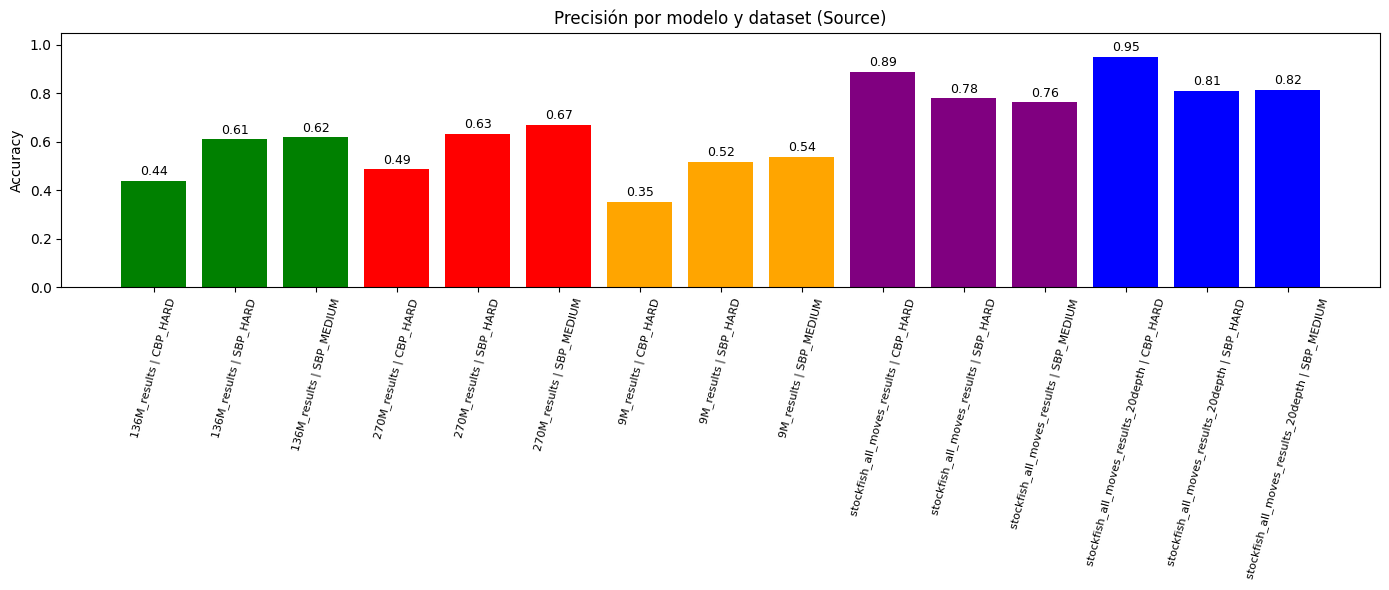

In [31]:
# Combina Model y Source como etiquetas para el eje x
accuracy_modelo_source['Label'] = accuracy_modelo_source['Model'] + ' | ' + accuracy_modelo_source['Source']

labels = accuracy_modelo_source['Label'].tolist()
values = accuracy_modelo_source['accuracy'].tolist()

# Función para asignar colores según el modelo
def asignar_color(label):
    if "9M" in label:
        return "orange"
    elif "136M" in label:
        return "green"
    elif "270M" in label:
        return "red"
    elif "stockfish_all_moves_results |" in label and "20depth" not in label:
        return "purple"
    elif "stockfish_all_moves_results_20depth" in label:
        return "blue"
    else:
        return "gray"

colors = [asignar_color(label) for label in labels]

# Plot
plt.figure(figsize=(14, 6))
bars = plt.bar(labels, values, color=colors)

# Etiquetas en las barras
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2,
             height + 0.01,
             f'{height:.2f}',
             ha='center',
             va='bottom',
             fontsize=9)

plt.ylabel('Accuracy')
plt.xticks(rotation=75, fontsize=8)
plt.title('Precisión por modelo y dataset (Source)')
plt.ylim(0, 1.05)
plt.tight_layout()

# Leyenda
legend_elements = [
    Patch(facecolor='orange', label='9M'),
    Patch(facecolor='green', label='136M'),
    Patch(facecolor='red', label='270M'),
    Patch(facecolor='purple', label='Stockfish all moves'),
    Patch(facecolor='blue', label='Stockfish 20 depth'),
]
#plt.legend(handles=legend_elements, title="Categorías", loc='lower left')

plt.show()


Vemos que el accuracy va mejorando en función del número de parámetros del modelo. Esto es natural: cuantos más parámetros tiene nuestro LST, mejor capacidad de razonamiento puede tener. Cabe destacar también la diferencia entre Stockfish con 50 ms / movimiento y Stockfish con profundidad 20, obteniendo este último una considerable mejor precisión.

Por otro lado, nuestro modelo funciona mejor en problemas de estrategia que de cálculo. Esto es comprensible, pues nuestro modelo no hace uso de búsqueda explícita de jugadas y puede sufrir si la mejor jugada reporta un beneficio siguiendo un juego táctico a varias jugadas vista. Sin embargo, para acertar en estrategia no se necesita tal potencia de cómputo, sino fijarse en factores más posicionales del tablero en el mismo momento de la jugada a realizar. Viendo estos resultados, podemos prever que nuestros motores jugarán de forma más estratégica que táctica.

### Distribución de predicciones

En este apartado, nos preguntamos: ¿existen sesgos entre las probabilidades de victoria que asigna cada modelo? ¿Cuanto mejor es el modelo, cómo cambian las probabilidades de victoria de las predicciones? Esto puede ser relevante si comparamos directamente las puntuaciones de diferentes modelos entre sí, ya que puede ser que algunos modelos sean sistemáticamente más optimistas que otros. También puede resultar interesante ver si, conforme el modelo tiene un tamaño mayor, la distribución se va pareciendo progresivamente más a la de Stockfish.

Para comprobar estas hipótesis, vamos a ver la distribución de probabilidades de victoria de la mejor jugada de cada modelo. Crearemos un histograma por cada dataset y por cada modelo.

In [32]:
predicciones

,Source,Puzzle_ID,FEN,Move,Move_UCI,Model,Predicted_Move,wp,cp,acierto
88538,CBP_HARD,001CBP,r3r3/5Rpp/p1k5/P1p5/7N/6P1/2p2P1P/2R3K1 b - - 0 1,Re1+,e8e1,136M_results,e8e2,0.259628,-284.0,False
88563,CBP_HARD,001CBP,r3r3/5Rpp/p1k5/P1p5/7N/6P1/2p2P1P/2R3K1 b - - 0 1,Re1+,e8e1,270M_results,e8e2,0.287577,-246.0,False
88513,CBP_HARD,001CBP,r3r3/5Rpp/p1k5/P1p5/7N/6P1/2p2P1P/2R3K1 b - - 0 1,Re1+,e8e1,9M_results,e8e2,0.234421,-321.0,False
88587,CBP_HARD,001CBP,r3r3/5Rpp/p1k5/P1p5/7N/6P1/2p2P1P/2R3K1 b - - 0 1,Re1+,e8e1,stockfish_all_moves_results,e8e1,0.452279,-52.0,True
88612,CBP_HARD,001CBP,r3r3/5Rpp/p1k5/P1p5/7N/6P1/2p2P1P/2R3K1 b - - 0 1,Re1+,e8e1,stockfish_all_moves_results_20depth,e8e1,0.452279,-52.0,True
...,...,...,...,...,...,...,...,...,...,...
13380,SBP_MEDIUM,076SBP,3r2k1/1b1r1pp1/p3qn1p/n1pp4/5Q2/P1N1PNPP/1P1R1...,Ne5,f3e5,136M_results,d2e2,0.452637,-51.0,False
13451,SBP_MEDIUM,076SBP,3r2k1/1b1r1pp1/p3qn1p/n1pp4/5Q2/P1N1PNPP/1P1R1...,Ne5,f3e5,270M_results,f3e5,0.473044,-29.0,True
13328,SBP_MEDIUM,076SBP,3r2k1/1b1r1pp1/p3qn1p/n1pp4/5Q2/P1N1PNPP/1P1R1...,Ne5,f3e5,9M_results,b2b4,0.482208,-19.0,False
13501,SBP_MEDIUM,076SBP,3r2k1/1b1r1pp1/p3qn1p/n1pp4/5Q2/P1N1PNPP/1P1R1...,Ne5,f3e5,stockfish_all_moves_results,f3e5,0.553188,58.0,True


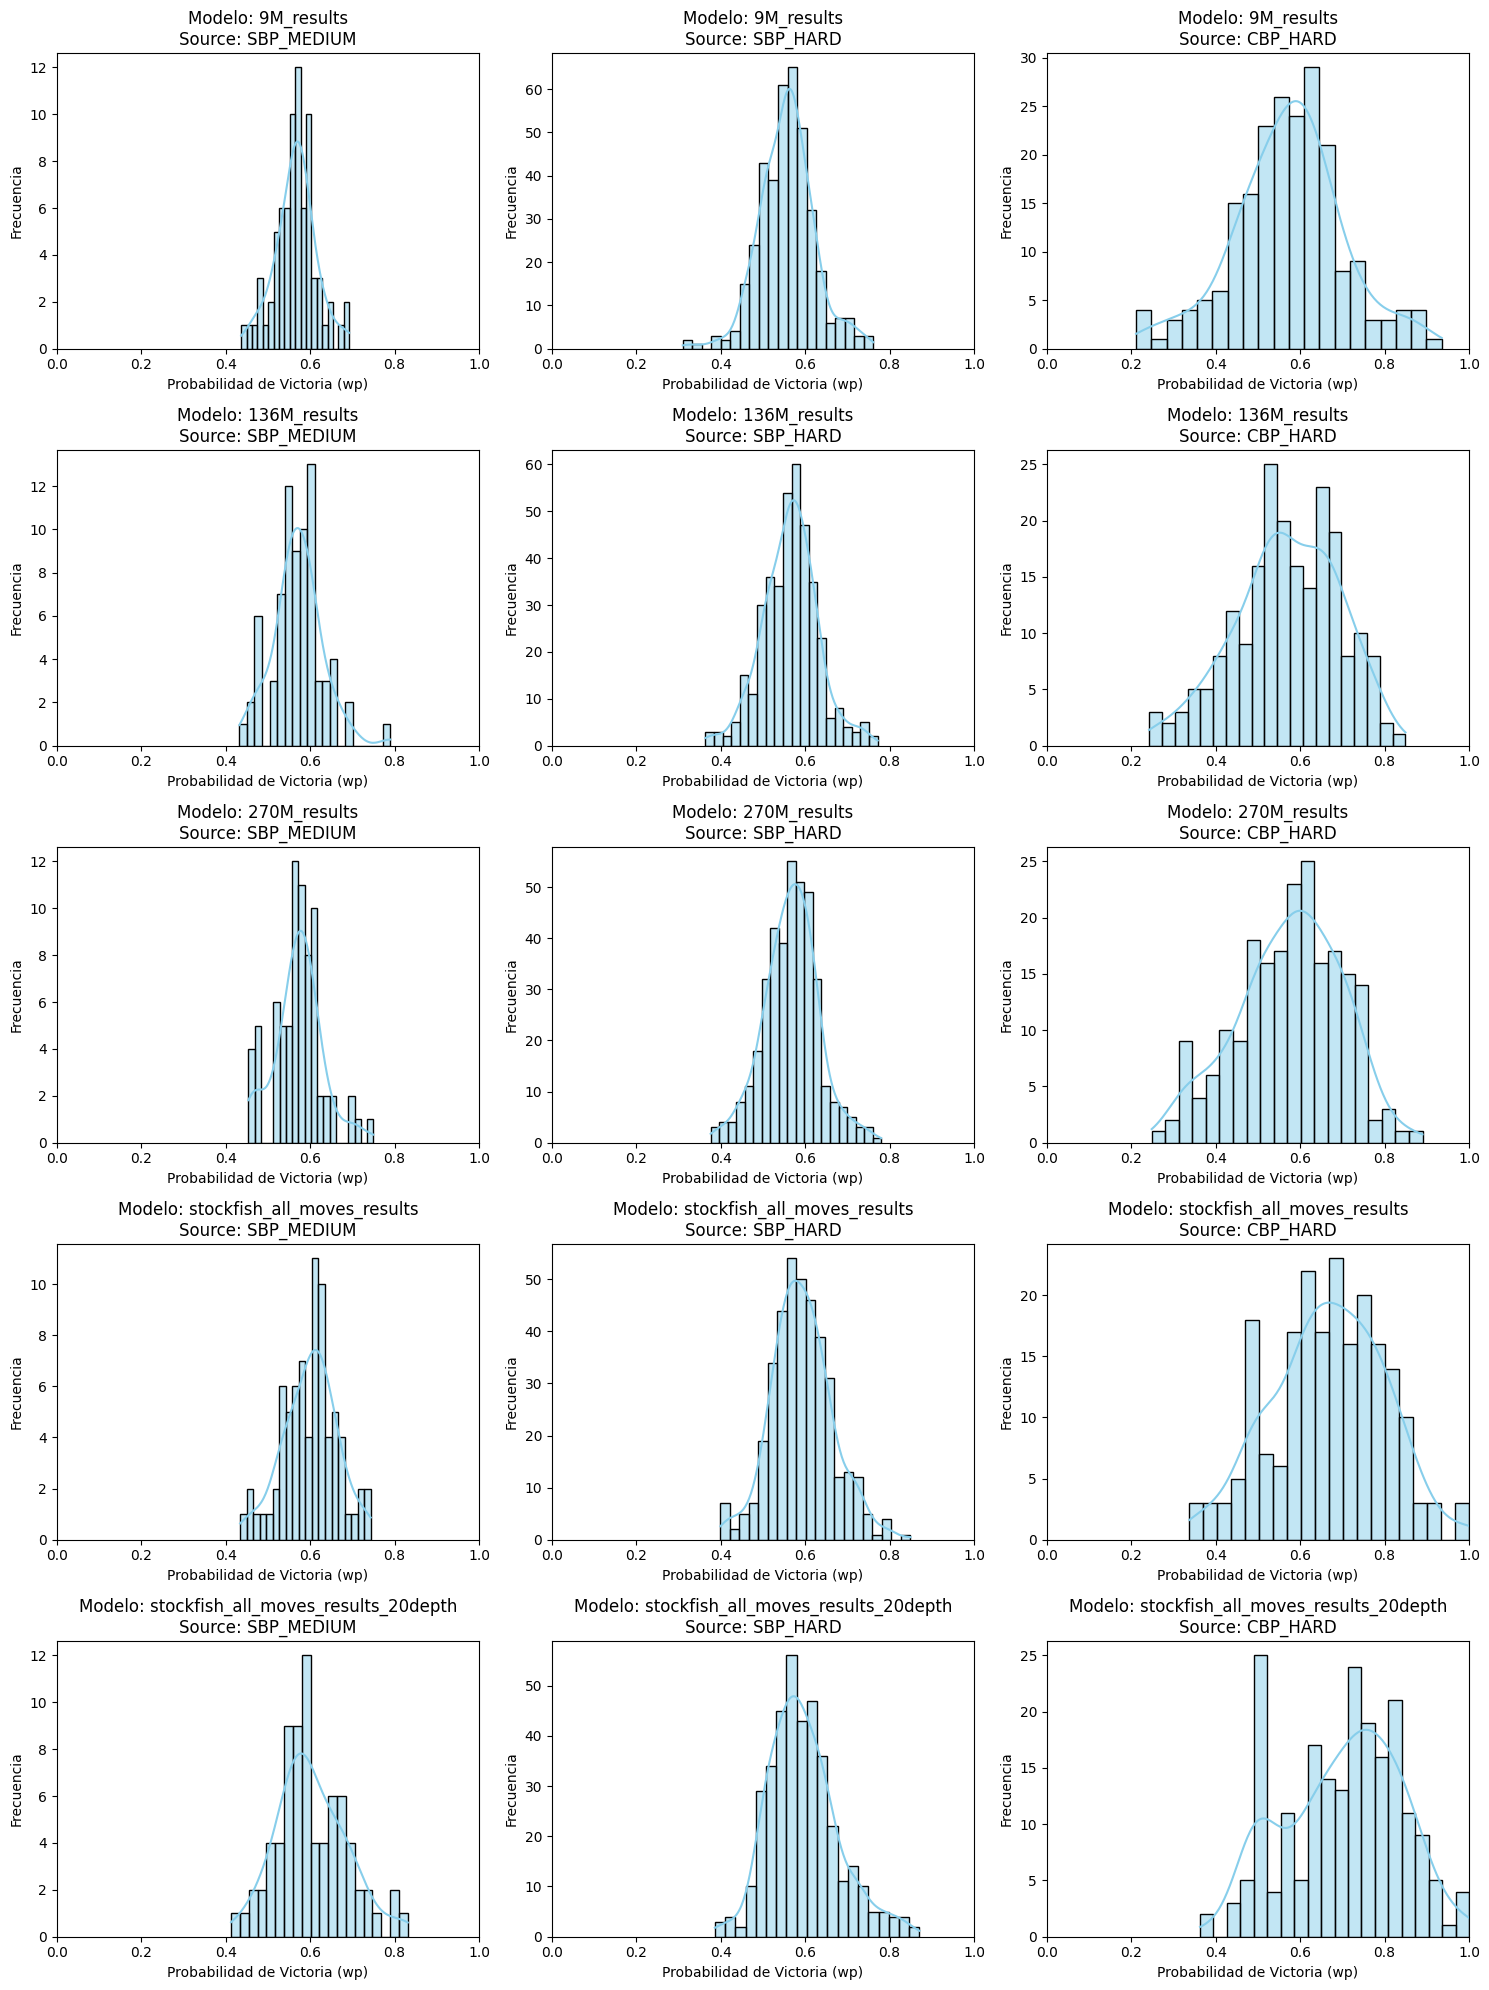

In [33]:
# Obtenemos las combinaciones posibles modelo-source
modelos = df_results['Model'].unique()
sources = df_results['Source'].unique()

# Ajustes del grid
n = 15
ncols = 3
nrows = (n + ncols - 1) // ncols

# Plot
plt.figure(figsize=(5 * ncols, 4 * nrows))

i = 0
for modelo in modelos:
    for source in sources:
        subset = predicciones[(predicciones['Model'] == modelo) & 
                                (predicciones['Source'] == source)]

        plt.subplot(nrows, ncols, i + 1)
        sns.histplot(subset['wp'], bins=20, kde=True, color='skyblue')
        plt.title(f'Modelo: {modelo}\nSource: {source}')
        plt.xlabel('Probabilidad de Victoria (wp)')
        plt.ylabel('Frecuencia')
        plt.xlim(0, 1)
        i += 1
plt.tight_layout()
plt.show()

### Análisis de %win

Vamos a obtener los tableros donde fallan nuestros modelos. Además, vamos a calcular la pérdida de wp de los fallos tomando como referencia los mejores resultados que tenemos en stockfish_20depth.

In [34]:
def obtener_subconjunto_modelo(df, puzzle_id, modelo):
    """Devuelve el subconjunto del dataframe correspondiente al modelo y Puzzle_ID dados."""
    return df[(df['Model'] == modelo) & (df['Puzzle_ID'] == puzzle_id)]

def calcular_wp_movimiento(df, puzzle_id, move, modelo='stockfish_all_moves_results_20depth'):
    """Calcula la wp del movimiento dado en un puzzle específico, según el modelo."""
    subset = obtener_subconjunto_modelo(df, puzzle_id, modelo)
    if subset.empty:
        return np.nan

    wp_series = subset[subset['Predicted_Move'] == move]['wp']
    return wp_series.iloc[0] if not wp_series.empty else np.nan

def calcular_wp_mejor(df, puzzle_id, modelo='stockfish_all_moves_results_20depth', force_max=False):
    """Calcula la wp del mejor movimiento para un puzzle y modelo dados.
        Si force_max es True, se calcula la wp del mejor movimiento de la jugada que el modelo predice
        Si force_max es False, se calcula la wp del mejor movimiento según el dataset.
    """
    subset = obtener_subconjunto_modelo(df, puzzle_id, modelo)
    if force_max:
        best_wp = subset['wp'].max() if not subset.empty else np.nan
    else:
        best_wp = subset[subset['Move_UCI'] == subset['Predicted_Move']]['wp'].max() if not subset.empty else np.nan
    return best_wp

In [35]:
predicciones['wp_stockfish'] = predicciones.apply(
    lambda fila: calcular_wp_movimiento(df_results, fila['Puzzle_ID'], fila['Predicted_Move']),
    axis=1
)

In [36]:

predicciones['wp_best_stockfish'] = predicciones.apply(
    lambda fila: calcular_wp_mejor(df_results, fila['Puzzle_ID']),
    axis=1
)

In [37]:
predicciones['perdida_wp'] = predicciones['wp_best_stockfish'] - predicciones['wp_stockfish']

In [38]:
print(predicciones)

           Source Puzzle_ID                                                FEN  Move Move_UCI                                Model Predicted_Move        wp     cp  acierto  wp_stockfish  wp_best_stockfish  perdida_wp
88538    CBP_HARD    001CBP  r3r3/5Rpp/p1k5/P1p5/7N/6P1/2p2P1P/2R3K1 b - - 0 1  Re1+     e8e1                         136M_results           e8e2  0.259628 -284.0    False      0.360221           0.452279    0.092058
88563    CBP_HARD    001CBP  r3r3/5Rpp/p1k5/P1p5/7N/6P1/2p2P1P/2R3K1 b - - 0 1  Re1+     e8e1                         270M_results           e8e2  0.287577 -246.0    False      0.360221           0.452279    0.092058
88513    CBP_HARD    001CBP  r3r3/5Rpp/p1k5/P1p5/7N/6P1/2p2P1P/2R3K1 b - - 0 1  Re1+     e8e1                           9M_results           e8e2  0.234421 -321.0    False      0.360221           0.452279    0.092058
88587    CBP_HARD    001CBP  r3r3/5Rpp/p1k5/P1p5/7N/6P1/2p2P1P/2R3K1 b - - 0 1  Re1+     e8e1          stockfish_all_moves_results  

Con la pérdida de wp se pueden realizar visualizaciones muy interesantes.

La primera que haremos será visualizar la relación entre las probabilidades de victoria que asignan nuestros LST contra Stockfish a los puzzles. Esta resulta de gran interés para evaluar la capacidad de estos modelos para aproximarse al juicio de un motor de ajedrez de referencia. Al representar cada predicción como un punto y colorearlo según si ambos sistemas aciertan o no el movimiento óptimo, se obtiene una visión clara de la concordancia entre ambos enfoques. Además, al desglosar los resultados por modelo y por tipo de puzzle (Source), se puede analizar cómo varía el rendimiento en función de la complejidad o naturaleza del problema, lo que permite identificar patrones de fortaleza o debilidad específicos de cada modelo.

In [39]:
# Para hacer más visual el gráfico, calculamos las etiquetas (acierto, acierto_stockfish)
df_grafico = predicciones.copy()

# Creamos un diccionario que mapea (Puzzle_ID, Move_UCI) -> acierto para stockfish
aciertos_stockfish = df_grafico[df_grafico['Model'] == 'stockfish_all_moves_results_20depth'][['Puzzle_ID', 'Move_UCI', 'acierto']].copy()
aciertos_stockfish = aciertos_stockfish.rename(columns={'acierto': 'acierto_stockfish'})

# Lo unimos con el resto del dataframe por Puzzle_ID y Move_UCI
df_grafico = df_grafico.merge(aciertos_stockfish, on=['Puzzle_ID', 'Move_UCI'], how='left')

def etiqueta_acierto_real(fila):
    if fila['acierto'] and fila['acierto_stockfish']:
        return 'Ambos aciertan'
    elif fila['acierto']:
        return 'Acierta Modelo'
    elif fila['acierto_stockfish']:
        return 'Acierta Stockfish'
    else:
        return 'Ninguno acierta'

df_grafico['acierto_combinado'] = df_grafico.apply(etiqueta_acierto_real, axis=1)


In [40]:
# Definimos una paleta para colorear los puntos
palette = {
    'Acierta Modelo': '#66c2a5',
    'Acierta Stockfish': '#fc8d62',
    'Ambos aciertan': '#8da0cb',
    'Ninguno acierta': '#e78ac3'
}

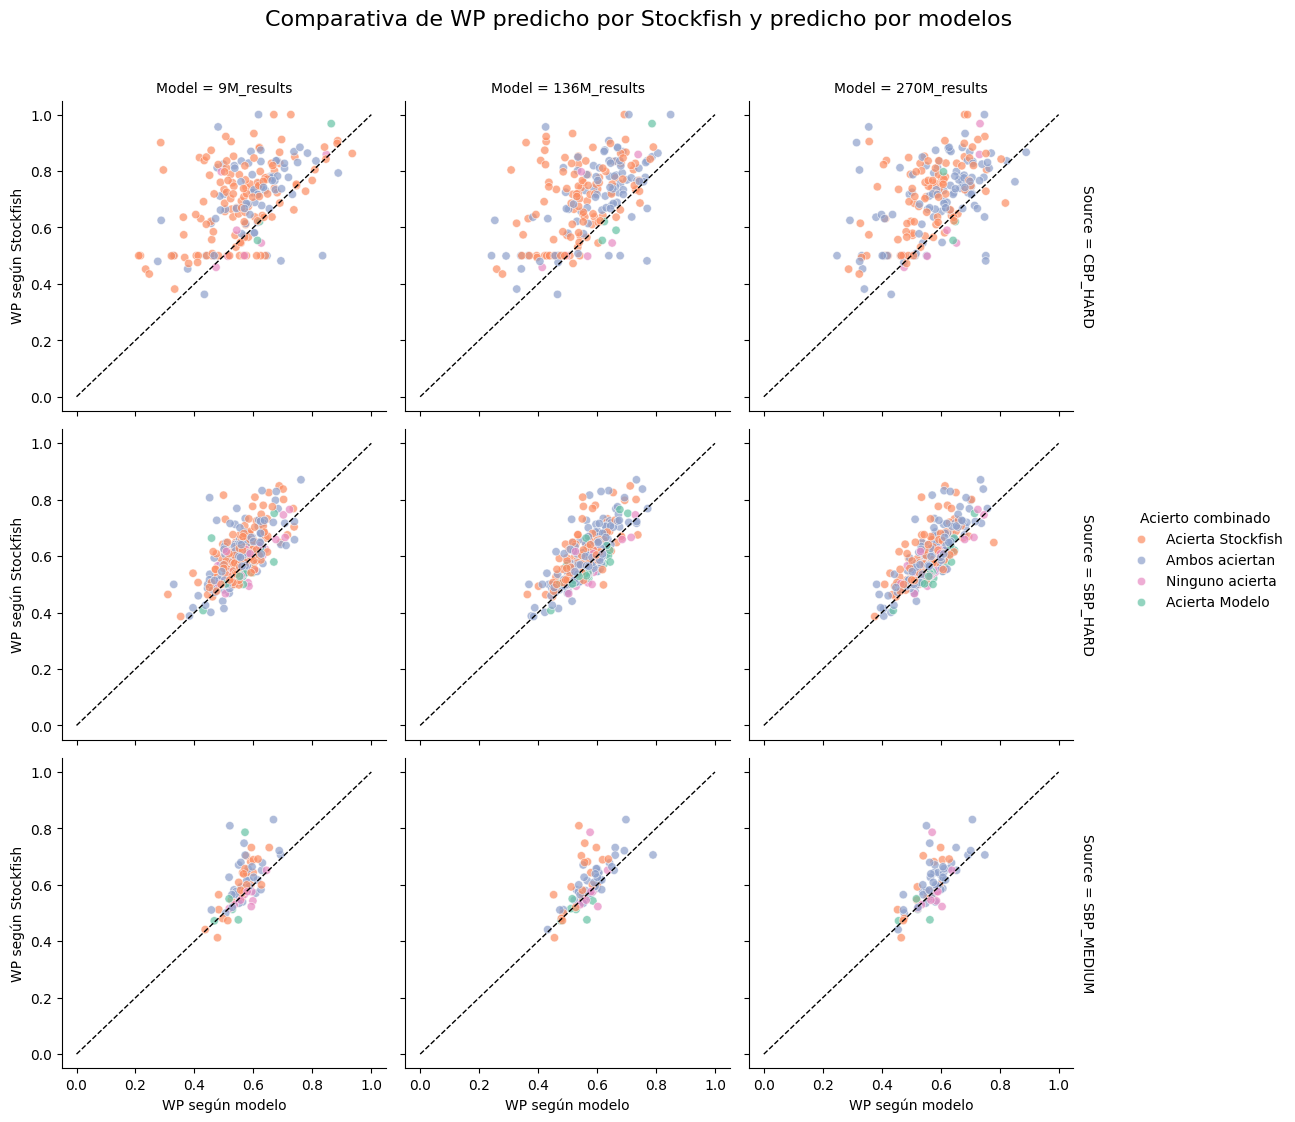

Conteo:
acierto_combinado                               Acierta Modelo  Acierta Stockfish  Ambos aciertan  Ninguno acierta
Source     Model                                                                                                  
CBP_HARD   136M_results                                    4.0              111.0            88.0              6.0
           270M_results                                    3.0              100.0            99.0              7.0
           9M_results                                      3.0              128.0            71.0              7.0
           stockfish_all_moves_results                     3.0               16.0           183.0              7.0
           stockfish_all_moves_results_20depth             NaN                NaN           199.0             10.0
SBP_HARD   136M_results                                   34.0              111.0           202.0             39.0
           270M_results                                   37.0          

In [41]:


# Seleccionar los modelos a comparar
modelos_lst = ['9M_results', '136M_results', '270M_results']
df_grafico_1 = df_grafico[df_grafico['Model'].isin(modelos_lst)].copy()

# Crear el grid de gráficos: columna = modelo, fila = source
g = sns.FacetGrid(
    df_grafico_1,
    row='Source',
    col='Model',
    col_order=modelos_lst,
    height=3.8,
    margin_titles=True,
    sharex=True,
    sharey=True
)

# Scatterplot con color por acierto
g.map_dataframe(
    sns.scatterplot,
    x='wp',  # Probabilidad de victoria segun el modelo probado
    y='wp_best_stockfish',   # Probabilidad de victoria de la jugada solución segun el modelo stockfish
    hue='acierto_combinado',
    palette=palette,
    alpha=0.7
)

# Línea de identidad en todos los gráficos
for ax in g.axes.flatten():
    ax.plot([0, 1], [0, 1], 'k--', lw=1)

# Etiquetas y leyenda
g.set_axis_labels("WP según modelo", "WP según Stockfish")
g.add_legend(title="Acierto combinado")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Comparativa de WP predicho por Stockfish y predicho por modelos", fontsize=16)
plt.show()

# Mostrar una tabla con el conteo
tabla_conteos = df_grafico.groupby(['Source', 'Model', 'acierto_combinado'])['Move_UCI'].count().unstack()
tabla_porcentajes = tabla_conteos.apply(lambda row: row / row.sum() * 100, axis=1)
print("Conteo:")
print(tabla_conteos)
print("Porcentaje:")
print(tabla_porcentajes.round(3))


En los gráficos anteriores, los tableros donde LST y Stockfish asignen puntuaciones parecidad estarán próximos a la línea identidad. Si Stockfish ofrece una mejor valoración desde su perspectiva, entonces los puntos estarán por encima de la línea. Si LST, por contra, ofrece una mejor valoración de la posición, el punto se mostrará por debajo de la línea. Otra interpretación posible es considerar a Stockfish como ground truth y calcular el error de predicción como la distancia horizontal entre el punto y la recta identidad.

En general, parece haber una tendencia a que Stockfish asigne puntuaciones más optimistas a los puzzles que LST. Esta tendencia aparece en todos los datasets, pero se vuelve bastante más marcada en los problemas de cálculo, donde la dispersión de los puntos también es alta. Antes, hemos visto que LST no funcionaba muy bien en este tipo de problemas en términos de accuracy. Aquí, vemos que realmente subestima su valoración en este tipo de posiciones, lo cual puede ser también un indicio de "ceguera" por parte del modelo a las consecuencias de la jugada a largo plazo. Esto es esperable, pues un problema de cálculo consiste en una serie de movimientos muy concretos que fuerzan una ventaja. Como nuestro LST carece de búsqueda explícita, su capacidad de explorar estas ramas es limitada.

En problemas de estrategia, parece haber una correlación más marcada entre las valoraciones de ambos modelos: los modelos producen respuestas más similares. Es destacable que la mayoría de tableros que no acierta el modelo pero sí Stockfish están por debajo de la línea de identidad: son casos donde Stockfish da una valoración menor que el modelo. Otro aspecto que llama la atención es la buena cantidad de ejemplos que sí acierta nuestro modelo pero no Stockfish. Esto sugiere que en dichos puzzles de estrategia existen varias soluciones con valoraciones muy similares: tanto que hasta Stockfish no acierta de forma exacta en casi un 20% de ellas.

Para analizar si realmente los movimientos que predice LST son medianamente buenos o no, vamos a cambiar la valoración del modelo LST de su mejor jugada con la que le da el propio Stockfish. 

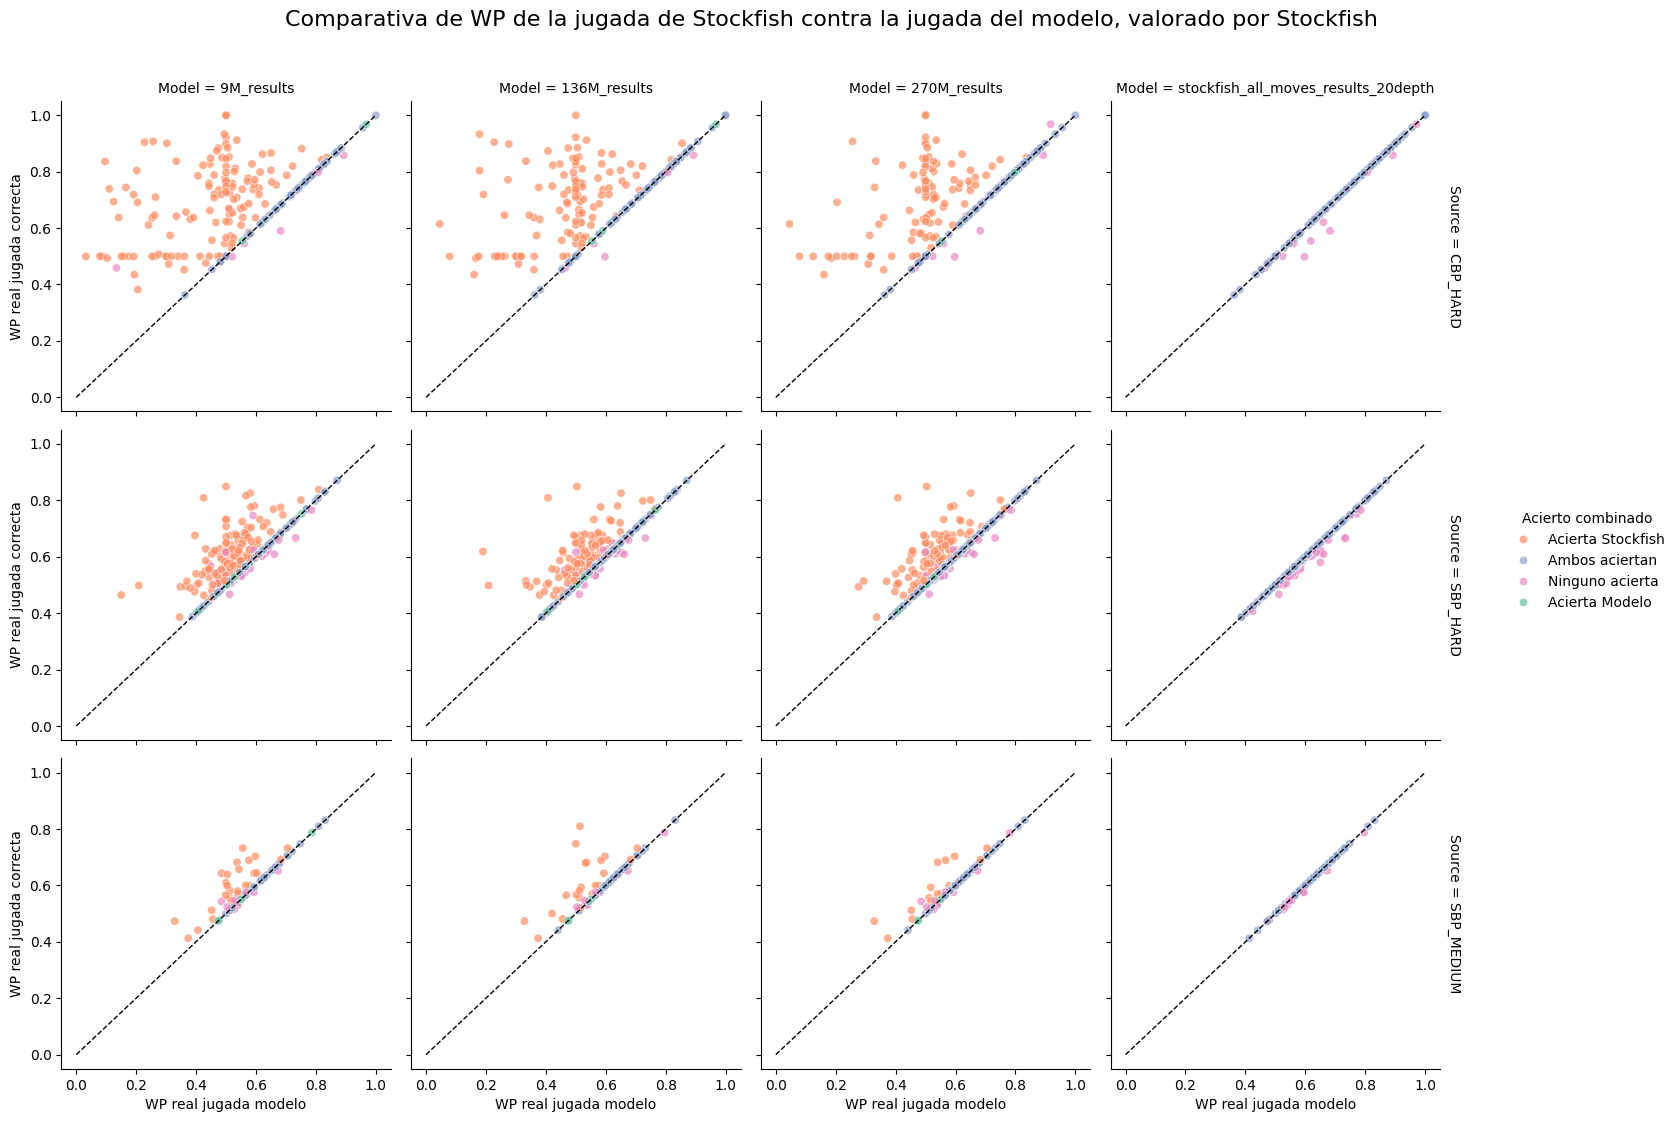

In [42]:
# Seleccionar los modelos a comparar
modelos_lst = ['9M_results', '136M_results', '270M_results', 'stockfish_all_moves_results_20depth']
df_grafico_2 = df_grafico[df_grafico['Model'].isin(modelos_lst)].copy()


# Crear el grid de gráficos: columna = modelo, fila = source
g = sns.FacetGrid(
    df_grafico_2,
    row='Source',
    col='Model',
    col_order=modelos_lst,
    height=3.8,
    margin_titles=True,
    sharex=True,
    sharey=True
)

# Scatterplot con color por acierto
g.map_dataframe(
    sns.scatterplot,
    x='wp_stockfish',
    y='wp_best_stockfish',
    hue='acierto_combinado',
    palette=palette,
    alpha=0.7
)

# Línea de identidad en todos los gráficos
for ax in g.axes.flatten():
    ax.plot([0, 1], [0, 1], 'k--', lw=1)

# Etiquetas y leyenda
g.set_axis_labels("WP real jugada modelo", "WP real jugada correcta")
g.add_legend(title="Acierto combinado")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Comparativa de WP de la jugada de Stockfish contra la jugada del modelo, valorado por Stockfish", fontsize=16)
plt.show()

Vemos que, en caso de acertar un modelo en un puzzle, el punto se representa forzosamente en la línea identidad: los puntos que se salen de ella son aquellos en los que la predicción falla.

En los problemas de cálculo, vemos cómo tenemos errores que cambian muy sustancialmente la valoración del tablero. Esto es típico de los problemas de cálculo: solo hay una jugada buena y hay bastante diferencia entre su valoración y la de las demás. Resulta muy llamativa esa forma de L espejada que siguen los puntos: esta se debe a que Stockfish es capaz de detectar situaciones de empate. Así, muchas de las valoraciones que hace pueden asociarse a empates. La línea vertical de la L se correspondería con problemas donde se puede ganar ventaja pero la jugada hecha lleva a empate, mientras que la línea horizontal representan problemas donde lo mejor que se podía conseguir era un empate pero se realiza una jugada perdedora.

Las diferencias entre valoraciones en estrategia son más moderadas, y hay una buena parte de puzzles donde ningún predictor acierta. En SBP_HARD, sin embargo, parece haber fallos más graves que en SBP_MEDIUM, probablemente relacionados con la dificultad del problema.

Si nos fijamos en la columna de Stockfish, vemos que el modelo, aunque no acierte algunos problemas, la valoración que da a la jugada a predecir es muy cercana a la jugada que propone. Esto nos da la seguridad de que Stockfish es un buen oráculo y que las puntuaciones que asigna a las jugadas son bastante precisas.

Ahora, vamos a calcular la pérdida de probabilidad de victoria media de cada modelo en cada dataset de manera cuantitativa. Este cálculo lo haremos de dos formas: considerando los ejemplos acertados por un lado, e ignorándolos por otro.

In [43]:
print("Media de pérdida de wp:")
tabla_wpl_medio = df_grafico.groupby(['Source', 'Model'])['perdida_wp'].mean().unstack()
print(tabla_wpl_medio.round(3))
print("Media de pérdida de wp en fallos:")
tabla_fallo_wpl_medio = df_grafico[df_grafico['acierto'] == False].groupby(['Source', 'Model'])['perdida_wp'].mean().unstack()
print(tabla_fallo_wpl_medio.round(3))

Media de pérdida de wp:
Model       136M_results  270M_results  9M_results  stockfish_all_moves_results  stockfish_all_moves_results_20depth
Source                                                                                                              
CBP_HARD           0.124         0.105       0.158                        0.007                               -0.002
SBP_HARD           0.025         0.021       0.034                        0.004                               -0.003
SBP_MEDIUM         0.024         0.012       0.026                        0.004                               -0.002
Media de pérdida de wp en fallos:
Model       136M_results  270M_results  9M_results  stockfish_all_moves_results  stockfish_all_moves_results_20depth
Source                                                                                                              
CBP_HARD           0.222         0.204       0.245                        0.062                               -0.039
SBP_HA

Vemos que conforme el modelo tiene más parámetros, las pérdidas se reducen poco a poco.

En problemas de cálculo, tenemos que la pérdida media de probabilidad de victoria es del 10,5% considerando jugadas correctas y del 20% considerando solo fallos para el mejor modelo (270M). Esto es una pérdida tremenda. Sin embargo, hay que tener en cuenta también el contexto del dataset: situaciones muy críticas donde solo hay un movimiento correcto que no es nada fácil de ver.

En problemas de estrategia, la pérdida es bastante menor: el fallo medio ronda el 5% de pérdida para 270M en la categoría difícil y del 3,8% en los intermedios.

Por supuesto, no podemos dar una cifra exacta a la pérdida que tiene nuestro oráculo, pues para ello necesitaríamos otro oráculo. Sin embargo, vemos que las diferencias entre las jugadas que ofrece y las del ground truth, valoradas por él mismo, tienden a tener una puntuación muy parecida. El resultado dado en la anterior tabla lo demuestra: la variación media de puntuación en cálculo es del 3,9% de WP, y de solo el 1,5% en problemas de estrategia difíciles.

En el siguiente gráfico, podemos ver los histogramas de las peérdidas en WP de los errores cometidos en cada dataset por cada modelo. En ella, vemos que los erores tienden a seguir una distribución normal, por lo que las medias calculadas parecen ser significativas. 

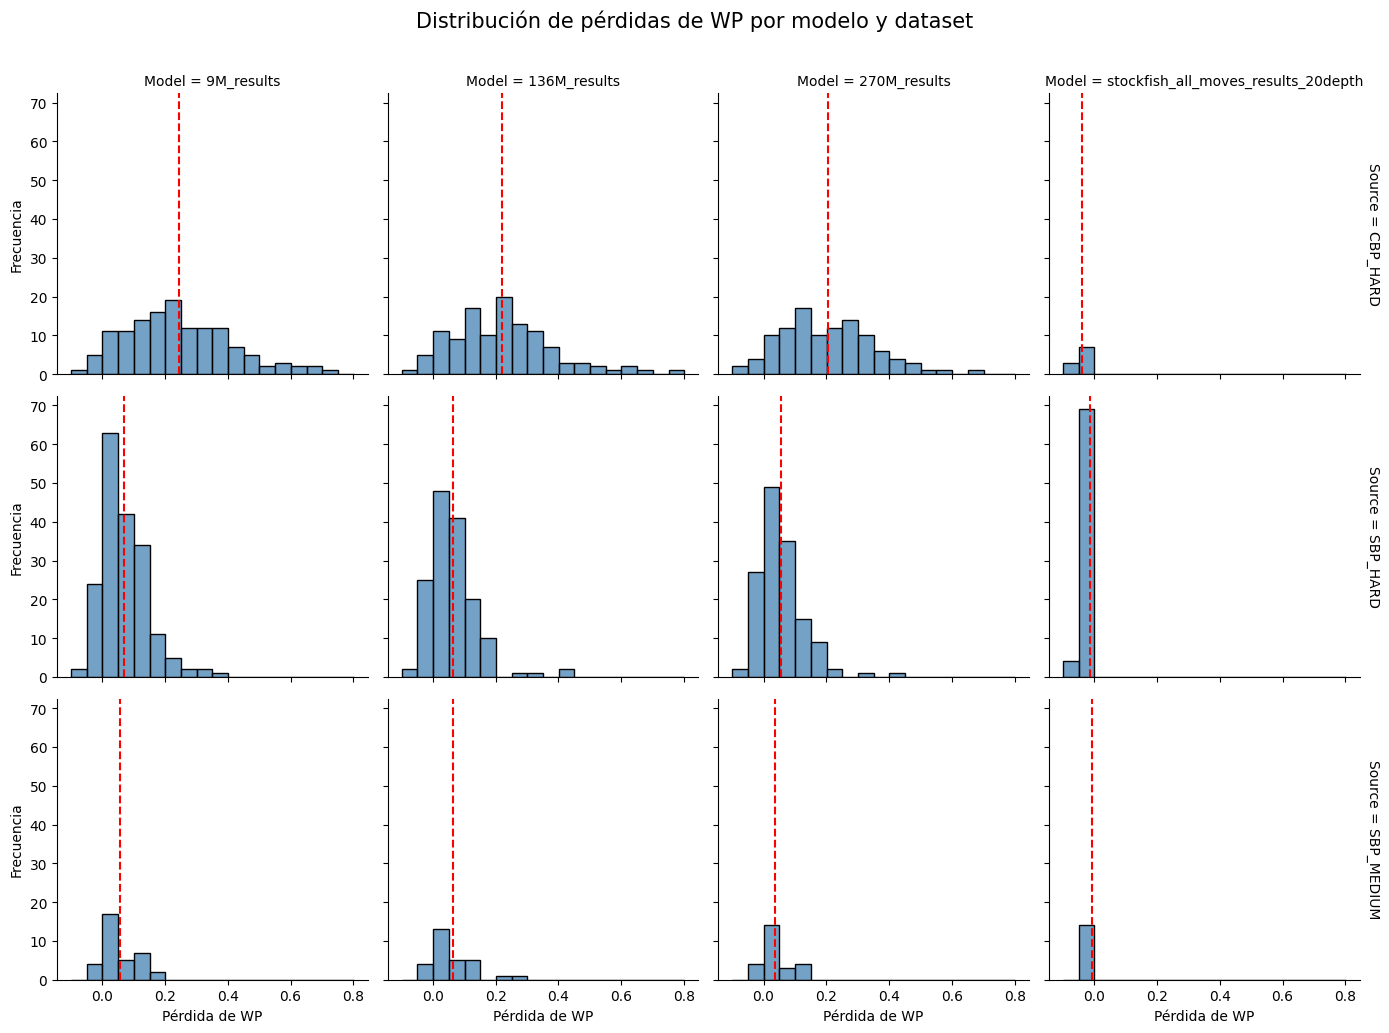

In [44]:
# Calcular el rango común de wp_loss
min_wp_loss = df_grafico['perdida_wp'].min()
max_wp_loss = df_grafico['perdida_wp'].max()

# Crear bins comunes (por ejemplo, de tamaño 0.05)
bin_width = 0.05
bins = np.arange(min_wp_loss, max_wp_loss + bin_width, bin_width)

def add_mean_line(data, **kwargs):
    mean = np.mean(data['perdida_wp'])
    plt.axvline(mean, color='red', linestyle='--')

# Crear grid de histogramas
g = sns.FacetGrid(
    df_grafico[df_grafico['acierto'] == False],
    row='Source',
    col='Model',
    col_order=modelos_lst,
    height=3.5,
    margin_titles=True,
    sharex=True,
    sharey=True
)

# Histograma
g.map_dataframe(
    sns.histplot,
    x='perdida_wp',
    bins=bins,          # Bins comunes
    color='steelblue',
    kde=False
)
g.map_dataframe(add_mean_line)

# Etiquetas
g.set_axis_labels("Pérdida de WP", "Frecuencia")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Distribución de pérdidas de WP por modelo y dataset", fontsize=15)
plt.show()

### Análisis cuantitativo de fallos

Vamos a distinguir diferentes tipos de fallos:

- Fallos simples: El movimiento no coincide con el propuesto por el dataset como el mejor.
- Errores: El modelo no ha predicho la respuesta correcta y la diferencia en win probability entre dicho movimiento y el movimiento correcto según Stockfish con profundidad 20 es de más de 0.05.
- Blunders: El modelo no ha predicho la respuesta correcta y la diferencia en win probability entre dicho movimiento y el movimiento correcto por Stockfish con profundidad 20 es de más de 0.1.

In [45]:
error_count = df_grafico[df_grafico['perdida_wp'] > 0.05].groupby(['Source', 'Model'])['Move_UCI'].count().unstack()
blunder_count = df_grafico[df_grafico['perdida_wp'] > 0.15].groupby(['Source', 'Model'])['Move_UCI'].count().unstack()
print(error_count)
print(blunder_count)

Model       136M_results  270M_results  9M_results  stockfish_all_moves_results
Source                                                                         
CBP_HARD             100            92         118                            9
SBP_HARD              75            63          97                           14
SBP_MEDIUM            12             7          14                            2
Model       136M_results  270M_results  9M_results  stockfish_all_moves_results
Source                                                                         
CBP_HARD            74.0          62.0        93.0                          3.0
SBP_HARD            14.0          13.0        21.0                          1.0
SBP_MEDIUM           2.0           NaN         2.0                          NaN


### Problemas fallados por todos los motores

Vamos a analizar las posiciones donde los motores han cometido más fallos.

In [46]:
errores_por_puzzle = df_grafico[df_grafico['acierto'] == False].groupby(['Puzzle_ID'])['Model'].nunique().sort_values(ascending=False)
problemas_fallados_por_todos = errores_por_puzzle[errores_por_puzzle > 4]
print(problemas_fallados_por_todos)
print('Numero de fallos:', len(problemas_fallados_por_todos))

Puzzle_ID
004CBP     5
029SBP     5
41SBPH     5
030SBP     5
070CBP     5
332SBPH    5
345SBPH    5
342SBPH    5
34SBPH     5
307SBPH    5
312SBPH    5
072SBP     5
354SBPH    5
129SBPH    5
206SBPH    5
148SBPH    5
274SBPH    5
250SBPH    5
201CBP     5
166CBP     5
75SBPH     5
77SBPH     5
Name: Model, dtype: int64
Numero de fallos: 22


En este conjunto de 22 problemas, todos los motores se han equivocado. ¿Es posible que haya un error en el etiquetado? ¿O puede que simplemente sean muy complicados? ¿Cuánta pérdida de wp provoca el fallo en cada uno de ellos?

Vamos a ir analizando estos problemas detenidamente. Para facilitar el análisis y hacerlo más visual, vamos a graficar los tableros con las jugadas que conforman el ground truth de color verde y las distintas alternativas propuestas por los modelos en una escala del azul al rojo en función de la pérdida de probabilidad de victoria en que se incurre al realizar el movimiento según Stockfish con profundidad 20.

In [47]:
import chess
import chess.svg
from IPython.display import SVG, display
from chess.svg import Arrow

def analiza_problema(puzzle_idx):
    print(f"Puzzle ID: {puzzle_idx}")
    
    # Obtenemos las entradas de cada modelo para el puzzle
    df_puzzle = df_grafico[df_grafico['Puzzle_ID'] == puzzle_idx]

    # Creamos el tablero
    fen = df_puzzle['FEN'].iloc[0]
    board = chess.Board(fen)

    # Jugada correcta
    jugada_correcta = chess.Move.from_uci(df_puzzle['Move_UCI'].iloc[0])

    # Jugadas de los modelos
    jugadas_modelos = df_puzzle['Predicted_Move'].tolist()
    jugadas_modelos = [chess.Move.from_uci(mov) for mov in jugadas_modelos if chess.Move.from_uci(mov) in board.legal_moves]
    
    # Dibujar flechas: verde para la jugada correcta, roja para las predichas
    flechas = [Arrow(jugada_correcta.from_square, jugada_correcta.to_square, color="#00cc00")]

    for mov in jugadas_modelos:
        if mov != jugada_correcta:
            flechas.append(Arrow(mov.from_square, mov.to_square, color="#cc0000"))

    # Mostrar tablero con flechas
    svg = chess.svg.board(board=board, size=400, arrows=flechas)
    display(SVG(svg))

    # Mostrar la tabla de resultados
    display(df_puzzle)


In [48]:
def analiza_problema(puzzle_idx, saturacion_error = 0.1):
    print(f"Puzzle ID: {puzzle_idx}")
    
    df_puzzle = df_grafico[df_grafico['Puzzle_ID'] == puzzle_idx]
    fen = df_puzzle['FEN'].iloc[0]
    board = chess.Board(fen)

    jugada_correcta = chess.Move.from_uci(df_puzzle['Move_UCI'].iloc[0])
    flechas = []

    # Escala de color personalizada (colormap de matplotlib)
    norm = mcolors.Normalize(vmin=df_puzzle["perdida_wp"].min(), vmax=saturacion_error)
    cmap = cm.get_cmap("coolwarm")  # o "Reds", "YlOrRd", etc.
    # Agregamos la jugada correcta en verde
    flechas.append(Arrow(jugada_correcta.from_square, jugada_correcta.to_square, color="#00cc00"))

    # Flechas para las jugadas erróneas, coloreadas por pérdida
    for _, row in df_puzzle.iterrows():
        move = chess.Move.from_uci(row["Predicted_Move"])
        perdida = row["perdida_wp"]
        rgba = cmap(norm(perdida))
        hex_color = mcolors.to_hex(rgba)
        flechas.append(Arrow(move.from_square, move.to_square, color=hex_color))

    # Mostrar el tablero con las flechas coloreadas
    svg = chess.svg.board(board=board, size=400, arrows=flechas)
    display(SVG(svg))

    display(df_puzzle)


Puzzle ID: 004CBP


/tmp/ipykernel_2465481/1499181793.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("coolwarm")  # o "Reds", "YlOrRd", etc.


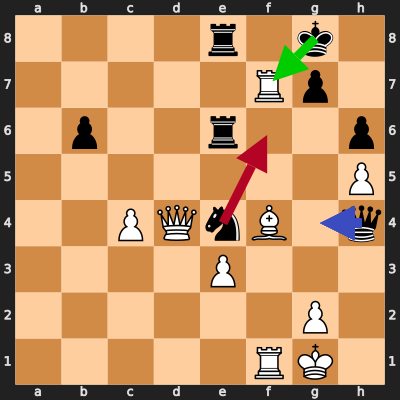

,Source,Puzzle_ID,FEN,Move,Move_UCI,Model,Predicted_Move,wp,cp,acierto,wp_stockfish,wp_best_stockfish,perdida_wp,acierto_stockfish,acierto_combinado
15,CBP_HARD,004CBP,4r1k1/5Rp1/1p2r2p/7P/2PQnB1q/4P3/6P1/5RK1 b - ...,Kxf7,g8f7,136M_results,h4g4,0.414019,-94.0,False,0.465077,0.458671,-0.006406,False,Ninguno acierta
16,CBP_HARD,004CBP,4r1k1/5Rp1/1p2r2p/7P/2PQnB1q/4P3/6P1/5RK1 b - ...,Kxf7,g8f7,270M_results,h4g4,0.475968,-26.0,False,0.465077,0.458671,-0.006406,False,Ninguno acierta
17,CBP_HARD,004CBP,4r1k1/5Rp1/1p2r2p/7P/2PQnB1q/4P3/6P1/5RK1 b - ...,Kxf7,g8f7,9M_results,e4f6,0.473378,-28.0,False,0.134338,0.458671,0.324333,False,Ninguno acierta
18,CBP_HARD,004CBP,4r1k1/5Rp1/1p2r2p/7P/2PQnB1q/4P3/6P1/5RK1 b - ...,Kxf7,g8f7,stockfish_all_moves_results,h4g4,0.471495,-31.0,False,0.465077,0.458671,-0.006406,False,Ninguno acierta
19,CBP_HARD,004CBP,4r1k1/5Rp1/1p2r2p/7P/2PQnB1q/4P3/6P1/5RK1 b - ...,Kxf7,g8f7,stockfish_all_moves_results_20depth,h4g4,0.465077,-38.0,False,0.465077,0.458671,-0.006406,False,Ninguno acierta


Puzzle ID: 029SBP


/tmp/ipykernel_2465481/1499181793.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("coolwarm")  # o "Reds", "YlOrRd", etc.


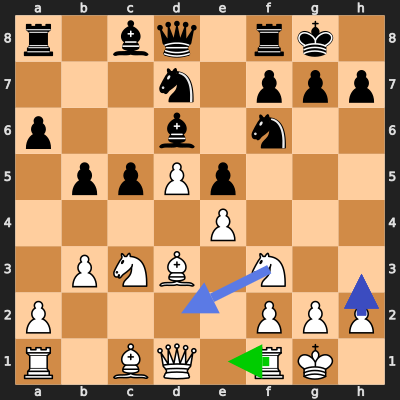

,Source,Puzzle_ID,FEN,Move,Move_UCI,Model,Predicted_Move,wp,cp,acierto,wp_stockfish,wp_best_stockfish,perdida_wp,acierto_stockfish,acierto_combinado
3115,SBP_MEDIUM,029SBP,r1bq1rk1/3n1ppp/p2b1n2/1ppPp3/4P3/1PNB1N2/P4PP...,Re1,f1e1,136M_results,f3d2,0.585412,93.0,False,0.581201,0.575814,-0.005387,False,Ninguno acierta
3116,SBP_MEDIUM,029SBP,r1bq1rk1/3n1ppp/p2b1n2/1ppPp3/4P3/1PNB1N2/P4PP...,Re1,f1e1,270M_results,h2h3,0.586943,95.0,False,0.593693,0.575814,-0.017879,False,Ninguno acierta
3117,SBP_MEDIUM,029SBP,r1bq1rk1/3n1ppp/p2b1n2/1ppPp3/4P3/1PNB1N2/P4PP...,Re1,f1e1,9M_results,h2h3,0.594611,104.0,False,0.593693,0.575814,-0.017879,False,Ninguno acierta
3118,SBP_MEDIUM,029SBP,r1bq1rk1/3n1ppp/p2b1n2/1ppPp3/4P3/1PNB1N2/P4PP...,Re1,f1e1,stockfish_all_moves_results,h2h3,0.607822,119.0,False,0.593693,0.575814,-0.017879,False,Ninguno acierta
3119,SBP_MEDIUM,029SBP,r1bq1rk1/3n1ppp/p2b1n2/1ppPp3/4P3/1PNB1N2/P4PP...,Re1,f1e1,stockfish_all_moves_results_20depth,h2h3,0.593693,103.0,False,0.593693,0.575814,-0.017879,False,Ninguno acierta


Puzzle ID: 41SBPH


/tmp/ipykernel_2465481/1499181793.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("coolwarm")  # o "Reds", "YlOrRd", etc.


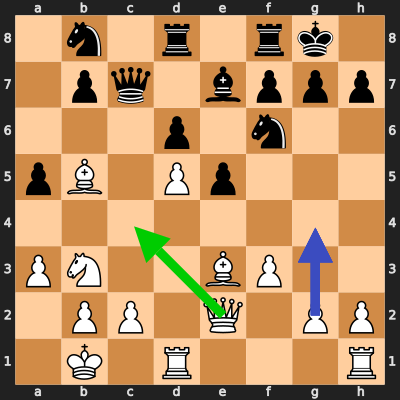

,Source,Puzzle_ID,FEN,Move,Move_UCI,Model,Predicted_Move,wp,cp,acierto,wp_stockfish,wp_best_stockfish,perdida_wp,acierto_stockfish,acierto_combinado
2650,SBP_HARD,41SBPH,1n1r1rk1/1pq1bppp/3p1n2/pB1Pp3/8/PN2BP2/1PP1Q1...,Qc4,e2c4,136M_results,g2g4,0.715707,250.0,False,0.732081,0.666463,-0.065618,False,Ninguno acierta
2651,SBP_HARD,41SBPH,1n1r1rk1/1pq1bppp/3p1n2/pB1Pp3/8/PN2BP2/1PP1Q1...,Qc4,e2c4,270M_results,g2g4,0.712781,246.0,False,0.732081,0.666463,-0.065618,False,Ninguno acierta
2652,SBP_HARD,41SBPH,1n1r1rk1/1pq1bppp/3p1n2/pB1Pp3/8/PN2BP2/1PP1Q1...,Qc4,e2c4,9M_results,g2g4,0.707837,240.0,False,0.732081,0.666463,-0.065618,False,Ninguno acierta
2653,SBP_HARD,41SBPH,1n1r1rk1/1pq1bppp/3p1n2/pB1Pp3/8/PN2BP2/1PP1Q1...,Qc4,e2c4,stockfish_all_moves_results,g2g4,0.739241,283.0,False,0.732081,0.666463,-0.065618,False,Ninguno acierta
2654,SBP_HARD,41SBPH,1n1r1rk1/1pq1bppp/3p1n2/pB1Pp3/8/PN2BP2/1PP1Q1...,Qc4,e2c4,stockfish_all_moves_results_20depth,g2g4,0.732081,273.0,False,0.732081,0.666463,-0.065618,False,Ninguno acierta


Puzzle ID: 030SBP


/tmp/ipykernel_2465481/1499181793.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("coolwarm")  # o "Reds", "YlOrRd", etc.


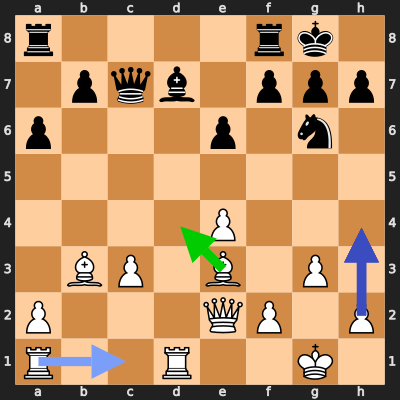

,Source,Puzzle_ID,FEN,Move,Move_UCI,Model,Predicted_Move,wp,cp,acierto,wp_stockfish,wp_best_stockfish,perdida_wp,acierto_stockfish,acierto_combinado
3120,SBP_MEDIUM,030SBP,r4rk1/1pqb1ppp/p3p1n1/8/4P3/1BP1B1P1/P3QP1P/R2...,Bd4,e3d4,136M_results,h2h4,0.541975,45.0,False,0.539500,0.529423,-0.010077,False,Ninguno acierta
3121,SBP_MEDIUM,030SBP,r4rk1/1pqb1ppp/p3p1n1/8/4P3/1BP1B1P1/P3QP1P/R2...,Bd4,e3d4,270M_results,h2h4,0.534679,37.0,False,0.539500,0.529423,-0.010077,False,Ninguno acierta
3122,SBP_MEDIUM,030SBP,r4rk1/1pqb1ppp/p3p1n1/8/4P3/1BP1B1P1/P3QP1P/R2...,Bd4,e3d4,9M_results,h2h4,0.535176,38.0,False,0.539500,0.529423,-0.010077,False,Ninguno acierta
3123,SBP_MEDIUM,030SBP,r4rk1/1pqb1ppp/p3p1n1/8/4P3/1BP1B1P1/P3QP1P/R2...,Bd4,e3d4,stockfish_all_moves_results,a1c1,0.560457,66.0,False,0.517483,0.529423,0.011940,False,Ninguno acierta
3124,SBP_MEDIUM,030SBP,r4rk1/1pqb1ppp/p3p1n1/8/4P3/1BP1B1P1/P3QP1P/R2...,Bd4,e3d4,stockfish_all_moves_results_20depth,h2h4,0.539500,43.0,False,0.539500,0.529423,-0.010077,False,Ninguno acierta


Puzzle ID: 070CBP


/tmp/ipykernel_2465481/1499181793.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("coolwarm")  # o "Reds", "YlOrRd", etc.


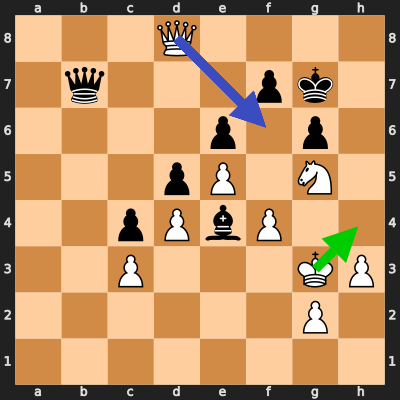

,Source,Puzzle_ID,FEN,Move,Move_UCI,Model,Predicted_Move,wp,cp,acierto,wp_stockfish,wp_best_stockfish,perdida_wp,acierto_stockfish,acierto_combinado
345,CBP_HARD,070CBP,3Q4/1q3pk1/4p1p1/3pP1N1/2pPbP2/2P3KP/6P1/8 w -...,Kh4,g3h4,136M_results,d8f6,0.739461,283.0,False,0.892563,0.858662,-0.033902,False,Ninguno acierta
346,CBP_HARD,070CBP,3Q4/1q3pk1/4p1p1/3pP1N1/2pPbP2/2P3KP/6P1/8 w -...,Kh4,g3h4,270M_results,d8f6,0.731528,272.0,False,0.892563,0.858662,-0.033902,False,Ninguno acierta
347,CBP_HARD,070CBP,3Q4/1q3pk1/4p1p1/3pP1N1/2pPbP2/2P3KP/6P1/8 w -...,Kh4,g3h4,9M_results,d8f6,0.847167,465.0,False,0.892563,0.858662,-0.033902,False,Ninguno acierta
348,CBP_HARD,070CBP,3Q4/1q3pk1/4p1p1/3pP1N1/2pPbP2/2P3KP/6P1/8 w -...,Kh4,g3h4,stockfish_all_moves_results,d8f6,0.817916,408.0,False,0.892563,0.858662,-0.033902,False,Ninguno acierta
349,CBP_HARD,070CBP,3Q4/1q3pk1/4p1p1/3pP1N1/2pPbP2/2P3KP/6P1/8 w -...,Kh4,g3h4,stockfish_all_moves_results_20depth,d8f6,0.892563,575.0,False,0.892563,0.858662,-0.033902,False,Ninguno acierta


Puzzle ID: 332SBPH


/tmp/ipykernel_2465481/1499181793.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("coolwarm")  # o "Reds", "YlOrRd", etc.


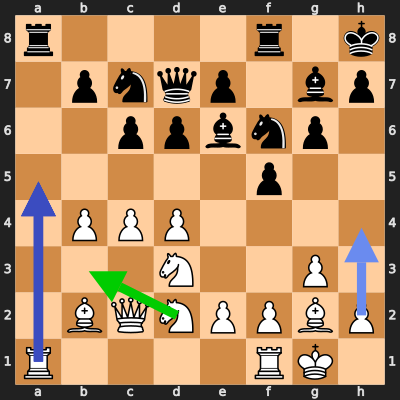

,Source,Puzzle_ID,FEN,Move,Move_UCI,Model,Predicted_Move,wp,cp,acierto,wp_stockfish,wp_best_stockfish,perdida_wp,acierto_stockfish,acierto_combinado
2335,SBP_HARD,332SBPH,r4r1k/1pnqp1bp/2ppbnp1/5p2/1PPP4/3N2P1/1BQNPPB...,Nb3,d2b3,136M_results,a1a5,0.570678,77.0,False,0.554098,0.5395,-0.014598,False,Ninguno acierta
2336,SBP_HARD,332SBPH,r4r1k/1pnqp1bp/2ppbnp1/5p2/1PPP4/3N2P1/1BQNPPB...,Nb3,d2b3,270M_results,a1a5,0.566286,72.0,False,0.554098,0.5395,-0.014598,False,Ninguno acierta
2337,SBP_HARD,332SBPH,r4r1k/1pnqp1bp/2ppbnp1/5p2/1PPP4/3N2P1/1BQNPPB...,Nb3,d2b3,9M_results,a1a5,0.560698,66.0,False,0.554098,0.5395,-0.014598,False,Ninguno acierta
2338,SBP_HARD,332SBPH,r4r1k/1pnqp1bp/2ppbnp1/5p2/1PPP4/3N2P1/1BQNPPB...,Nb3,d2b3,stockfish_all_moves_results,h2h4,0.552278,57.0,False,0.536754,0.5395,0.002745,False,Ninguno acierta
2339,SBP_HARD,332SBPH,r4r1k/1pnqp1bp/2ppbnp1/5p2/1PPP4/3N2P1/1BQNPPB...,Nb3,d2b3,stockfish_all_moves_results_20depth,a1a5,0.554098,59.0,False,0.554098,0.5395,-0.014598,False,Ninguno acierta


Puzzle ID: 345SBPH


/tmp/ipykernel_2465481/1499181793.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("coolwarm")  # o "Reds", "YlOrRd", etc.


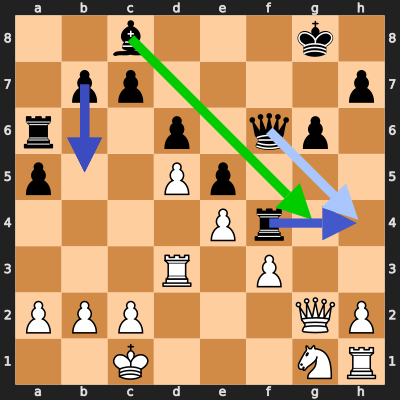

,Source,Puzzle_ID,FEN,Move,Move_UCI,Model,Predicted_Move,wp,cp,acierto,wp_stockfish,wp_best_stockfish,perdida_wp,acierto_stockfish,acierto_combinado
2405,SBP_HARD,345SBPH,2b3k1/1pp4p/r2p1qp1/p2Pp3/4Pr2/3R1P2/PPP3QP/2K...,Bg4,c8g4,136M_results,b7b5,0.543443,47.0,False,0.564987,0.53309,-0.031897,False,Ninguno acierta
2406,SBP_HARD,345SBPH,2b3k1/1pp4p/r2p1qp1/p2Pp3/4Pr2/3R1P2/PPP3QP/2K...,Bg4,c8g4,270M_results,f4h4,0.548172,52.0,False,0.561364,0.53309,-0.028274,False,Ninguno acierta
2407,SBP_HARD,345SBPH,2b3k1/1pp4p/r2p1qp1/p2Pp3/4Pr2/3R1P2/PPP3QP/2K...,Bg4,c8g4,9M_results,f6h4,0.525557,27.0,False,0.521159,0.53309,0.011931,False,Ninguno acierta
2408,SBP_HARD,345SBPH,2b3k1/1pp4p/r2p1qp1/p2Pp3/4Pr2/3R1P2/PPP3QP/2K...,Bg4,c8g4,stockfish_all_moves_results,b7b5,0.576713,84.0,False,0.564987,0.53309,-0.031897,False,Ninguno acierta
2409,SBP_HARD,345SBPH,2b3k1/1pp4p/r2p1qp1/p2Pp3/4Pr2/3R1P2/PPP3QP/2K...,Bg4,c8g4,stockfish_all_moves_results_20depth,b7b5,0.564987,71.0,False,0.564987,0.53309,-0.031897,False,Ninguno acierta


Puzzle ID: 342SBPH


/tmp/ipykernel_2465481/1499181793.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("coolwarm")  # o "Reds", "YlOrRd", etc.


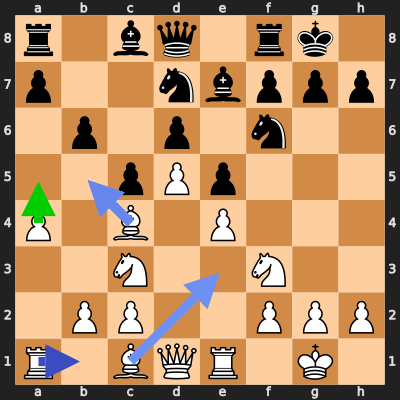

,Source,Puzzle_ID,FEN,Move,Move_UCI,Model,Predicted_Move,wp,cp,acierto,wp_stockfish,wp_best_stockfish,perdida_wp,acierto_stockfish,acierto_combinado
2390,SBP_HARD,342SBPH,r1bq1rk1/p2nbppp/1p1p1n2/2pPp3/P1B1P3/2N2N2/1P...,a5,a4a5,136M_results,c4b5,0.619140,131.0,False,0.593693,0.600779,0.007086,False,Ninguno acierta
2391,SBP_HARD,342SBPH,r1bq1rk1/p2nbppp/1p1p1n2/2pPp3/P1B1P3/2N2N2/1P...,a5,a4a5,270M_results,c4b5,0.620047,133.0,False,0.593693,0.600779,0.007086,False,Ninguno acierta
2392,SBP_HARD,342SBPH,r1bq1rk1/p2nbppp/1p1p1n2/2pPp3/P1B1P3/2N2N2/1P...,a5,a4a5,9M_results,c4b5,0.613060,124.0,False,0.593693,0.600779,0.007086,False,Ninguno acierta
2393,SBP_HARD,342SBPH,r1bq1rk1/p2nbppp/1p1p1n2/2pPp3/P1B1P3/2N2N2/1P...,a5,a4a5,stockfish_all_moves_results,c1e3,0.606065,117.0,False,0.591026,0.600779,0.009753,False,Ninguno acierta
2394,SBP_HARD,342SBPH,r1bq1rk1/p2nbppp/1p1p1n2/2pPp3/P1B1P3/2N2N2/1P...,a5,a4a5,stockfish_all_moves_results_20depth,a1b1,0.608700,120.0,False,0.608700,0.600779,-0.007921,False,Ninguno acierta


Puzzle ID: 34SBPH


/tmp/ipykernel_2465481/1499181793.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("coolwarm")  # o "Reds", "YlOrRd", etc.


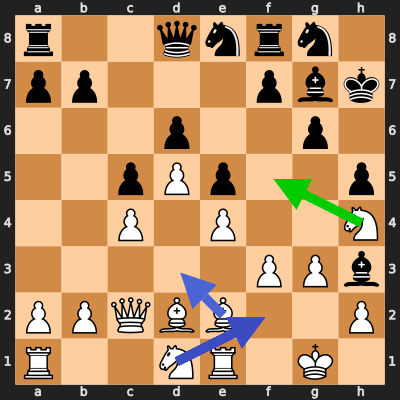

,Source,Puzzle_ID,FEN,Move,Move_UCI,Model,Predicted_Move,wp,cp,acierto,wp_stockfish,wp_best_stockfish,perdida_wp,acierto_stockfish,acierto_combinado
2430,SBP_HARD,34SBPH,r2qnrn1/pp3pbk/3p2p1/2pPp2p/2P1P2N/5PPb/PPQBB2...,Nf5,h4f5,136M_results,d1f2,0.627294,141.0,False,0.640627,0.621773,-0.018854,False,Ninguno acierta
2431,SBP_HARD,34SBPH,r2qnrn1/pp3pbk/3p2p1/2pPp2p/2P1P2N/5PPb/PPQBB2...,Nf5,h4f5,270M_results,d1f2,0.622731,136.0,False,0.640627,0.621773,-0.018854,False,Ninguno acierta
2432,SBP_HARD,34SBPH,r2qnrn1/pp3pbk/3p2p1/2pPp2p/2P1P2N/5PPb/PPQBB2...,Nf5,h4f5,9M_results,d1f2,0.612155,123.0,False,0.640627,0.621773,-0.018854,False,Ninguno acierta
2433,SBP_HARD,34SBPH,r2qnrn1/pp3pbk/3p2p1/2pPp2p/2P1P2N/5PPb/PPQBB2...,Nf5,h4f5,stockfish_all_moves_results,e2d3,0.632107,147.0,False,0.633818,0.621773,-0.012045,False,Ninguno acierta
2434,SBP_HARD,34SBPH,r2qnrn1/pp3pbk/3p2p1/2pPp2p/2P1P2N/5PPb/PPQBB2...,Nf5,h4f5,stockfish_all_moves_results_20depth,d1f2,0.640627,157.0,False,0.640627,0.621773,-0.018854,False,Ninguno acierta


Puzzle ID: 307SBPH


/tmp/ipykernel_2465481/1499181793.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("coolwarm")  # o "Reds", "YlOrRd", etc.


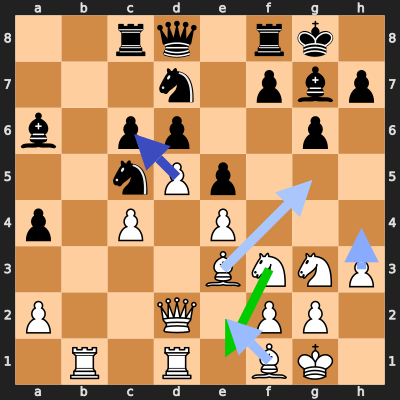

,Source,Puzzle_ID,FEN,Move,Move_UCI,Model,Predicted_Move,wp,cp,acierto,wp_stockfish,wp_best_stockfish,perdida_wp,acierto_stockfish,acierto_combinado
2195,SBP_HARD,307SBPH,2rq1rk1/3n1pbp/b1pp2p1/2nPp3/p1P1P3/4BNNP/P2Q1...,Ne1,f3e1,136M_results,h3h4,0.554865,59.0,False,0.541329,0.561364,0.020035,False,Ninguno acierta
2196,SBP_HARD,307SBPH,2rq1rk1/3n1pbp/b1pp2p1/2nPp3/p1P1P3/4BNNP/P2Q1...,Ne1,f3e1,270M_results,e3g5,0.552700,57.0,False,0.531257,0.561364,0.030107,False,Ninguno acierta
2197,SBP_HARD,307SBPH,2rq1rk1/3n1pbp/b1pp2p1/2nPp3/p1P1P3/4BNNP/P2Q1...,Ne1,f3e1,9M_results,e3g5,0.563140,68.0,False,0.531257,0.561364,0.030107,False,Ninguno acierta
2198,SBP_HARD,307SBPH,2rq1rk1/3n1pbp/b1pp2p1/2nPp3/p1P1P3/4BNNP/P2Q1...,Ne1,f3e1,stockfish_all_moves_results,f1e2,0.549545,54.0,False,0.535839,0.561364,0.025525,False,Ninguno acierta
2199,SBP_HARD,307SBPH,2rq1rk1/3n1pbp/b1pp2p1/2nPp3/p1P1P3/4BNNP/P2Q1...,Ne1,f3e1,stockfish_all_moves_results_20depth,d5c6,0.565892,72.0,False,0.565892,0.561364,-0.004528,False,Ninguno acierta


Puzzle ID: 312SBPH


/tmp/ipykernel_2465481/1499181793.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("coolwarm")  # o "Reds", "YlOrRd", etc.


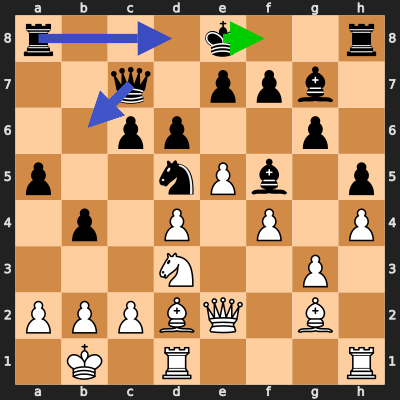

,Source,Puzzle_ID,FEN,Move,Move_UCI,Model,Predicted_Move,wp,cp,acierto,wp_stockfish,wp_best_stockfish,perdida_wp,acierto_stockfish,acierto_combinado
2225,SBP_HARD,312SBPH,r3k2r/2q1ppb1/2pp2p1/p2nPb1p/1p1P1P1P/3N2P1/PP...,Kf8,e8f8,136M_results,c7b6,0.567457,73.0,False,0.581201,0.557734,-0.023467,False,Ninguno acierta
2226,SBP_HARD,312SBPH,r3k2r/2q1ppb1/2pp2p1/p2nPb1p/1p1P1P1P/3N2P1/PP...,Kf8,e8f8,270M_results,c7b6,0.592662,101.0,False,0.581201,0.557734,-0.023467,False,Ninguno acierta
2227,SBP_HARD,312SBPH,r3k2r/2q1ppb1/2pp2p1/p2nPb1p/1p1P1P1P/3N2P1/PP...,Kf8,e8f8,9M_results,c7b6,0.575897,83.0,False,0.581201,0.557734,-0.023467,False,Ninguno acierta
2228,SBP_HARD,312SBPH,r3k2r/2q1ppb1/2pp2p1/p2nPb1p/1p1P1P1P/3N2P1/PP...,Kf8,e8f8,stockfish_all_moves_results,c7b6,0.596355,106.0,False,0.581201,0.557734,-0.023467,False,Ninguno acierta
2229,SBP_HARD,312SBPH,r3k2r/2q1ppb1/2pp2p1/p2nPb1p/1p1P1P1P/3N2P1/PP...,Kf8,e8f8,stockfish_all_moves_results_20depth,a8d8,0.583887,92.0,False,0.583887,0.557734,-0.026153,False,Ninguno acierta


Puzzle ID: 072SBP


/tmp/ipykernel_2465481/1499181793.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("coolwarm")  # o "Reds", "YlOrRd", etc.


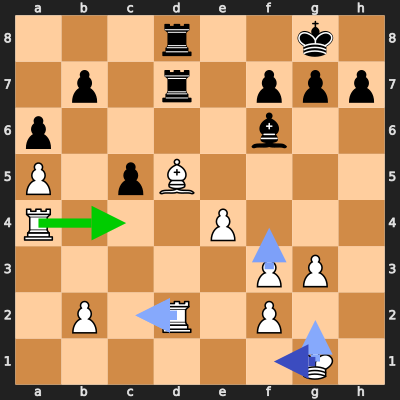

,Source,Puzzle_ID,FEN,Move,Move_UCI,Model,Predicted_Move,wp,cp,acierto,wp_stockfish,wp_best_stockfish,perdida_wp,acierto_stockfish,acierto_combinado
3330,SBP_MEDIUM,072SBP,3r2k1/1p1r1ppp/p4b2/P1pB4/R3P3/5PP1/1P1R1P2/6K...,Rc4,a4c4,136M_results,g1g2,0.579333,86.0,False,0.566796,0.575814,0.009018,False,Ninguno acierta
3331,SBP_MEDIUM,072SBP,3r2k1/1p1r1ppp/p4b2/P1pB4/R3P3/5PP1/1P1R1P2/6K...,Rc4,a4c4,270M_results,d2c2,0.590495,99.0,False,0.566796,0.575814,0.009018,False,Ninguno acierta
3332,SBP_MEDIUM,072SBP,3r2k1/1p1r1ppp/p4b2/P1pB4/R3P3/5PP1/1P1R1P2/6K...,Rc4,a4c4,9M_results,d2c2,0.578735,86.0,False,0.566796,0.575814,0.009018,False,Ninguno acierta
3333,SBP_MEDIUM,072SBP,3r2k1/1p1r1ppp/p4b2/P1pB4/R3P3/5PP1/1P1R1P2/6K...,Rc4,a4c4,stockfish_all_moves_results,f3f4,0.599011,109.0,False,0.570409,0.575814,0.005405,False,Ninguno acierta
3334,SBP_MEDIUM,072SBP,3r2k1/1p1r1ppp/p4b2/P1pB4/R3P3/5PP1/1P1R1P2/6K...,Rc4,a4c4,stockfish_all_moves_results_20depth,g1f1,0.594581,104.0,False,0.594581,0.575814,-0.018767,False,Ninguno acierta


Puzzle ID: 354SBPH


/tmp/ipykernel_2465481/1499181793.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("coolwarm")  # o "Reds", "YlOrRd", etc.


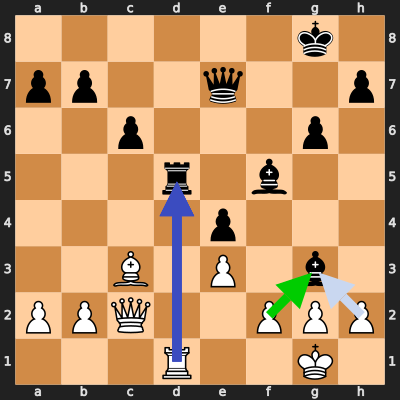

,Source,Puzzle_ID,FEN,Move,Move_UCI,Model,Predicted_Move,wp,cp,acierto,wp_stockfish,wp_best_stockfish,perdida_wp,acierto_stockfish,acierto_combinado
2455,SBP_HARD,354SBPH,6k1/pp2q2p/2p3p1/3r1b2/4p3/2B1P1b1/PPQ2PPP/3R2...,fxg3,f2g3,136M_results,d1d5,0.560603,66.0,False,0.546809,0.53767,-0.009139,False,Ninguno acierta
2456,SBP_HARD,354SBPH,6k1/pp2q2p/2p3p1/3r1b2/4p3/2B1P1b1/PPQ2PPP/3R2...,fxg3,f2g3,270M_results,d1d5,0.554308,59.0,False,0.546809,0.53767,-0.009139,False,Ninguno acierta
2457,SBP_HARD,354SBPH,6k1/pp2q2p/2p3p1/3r1b2/4p3/2B1P1b1/PPQ2PPP/3R2...,fxg3,f2g3,9M_results,h2g3,0.560515,66.0,False,0.500000,0.53767,0.037670,False,Ninguno acierta
2458,SBP_HARD,354SBPH,6k1/pp2q2p/2p3p1/3r1b2/4p3/2B1P1b1/PPQ2PPP/3R2...,fxg3,f2g3,stockfish_all_moves_results,d1d5,0.578510,86.0,False,0.546809,0.53767,-0.009139,False,Ninguno acierta
2459,SBP_HARD,354SBPH,6k1/pp2q2p/2p3p1/3r1b2/4p3/2B1P1b1/PPQ2PPP/3R2...,fxg3,f2g3,stockfish_all_moves_results_20depth,d1d5,0.546809,51.0,False,0.546809,0.53767,-0.009139,False,Ninguno acierta


Puzzle ID: 129SBPH


/tmp/ipykernel_2465481/1499181793.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("coolwarm")  # o "Reds", "YlOrRd", etc.


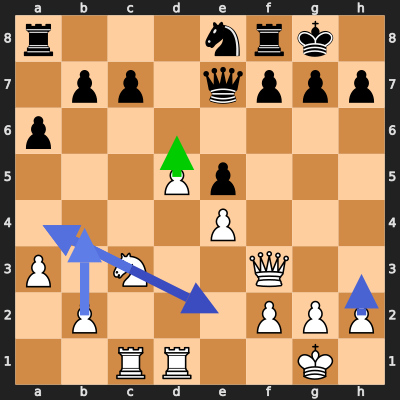

,Source,Puzzle_ID,FEN,Move,Move_UCI,Model,Predicted_Move,wp,cp,acierto,wp_stockfish,wp_best_stockfish,perdida_wp,acierto_stockfish,acierto_combinado
1205,SBP_HARD,129SBPH,r3nrk1/1pp1qppp/p7/3Pp3/4P3/P1N2Q2/1P3PPP/2RR2...,d6,d5d6,136M_results,c3a4,0.559419,64.0,False,0.524834,0.516563,-0.008270,False,Ninguno acierta
1206,SBP_HARD,129SBPH,r3nrk1/1pp1qppp/p7/3Pp3/4P3/P1N2Q2/1P3PPP/2RR2...,d6,d5d6,270M_results,h2h3,0.558841,64.0,False,0.528505,0.516563,-0.011942,False,Ninguno acierta
1207,SBP_HARD,129SBPH,r3nrk1/1pp1qppp/p7/3Pp3/4P3/P1N2Q2/1P3PPP/2RR2...,d6,d5d6,9M_results,c3a4,0.553229,58.0,False,0.524834,0.516563,-0.008270,False,Ninguno acierta
1208,SBP_HARD,129SBPH,r3nrk1/1pp1qppp/p7/3Pp3/4P3/P1N2Q2/1P3PPP/2RR2...,d6,d5d6,stockfish_all_moves_results,b2b4,0.533090,36.0,False,0.521159,0.516563,-0.004596,False,Ninguno acierta
1209,SBP_HARD,129SBPH,r3nrk1/1pp1qppp/p7/3Pp3/4P3/P1N2Q2/1P3PPP/2RR2...,d6,d5d6,stockfish_all_moves_results_20depth,c3e2,0.534923,38.0,False,0.534923,0.516563,-0.018360,False,Ninguno acierta


Puzzle ID: 206SBPH


/tmp/ipykernel_2465481/1499181793.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("coolwarm")  # o "Reds", "YlOrRd", etc.


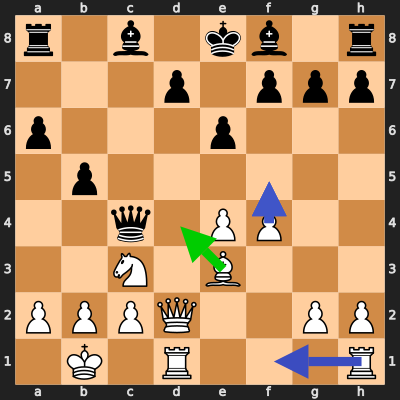

,Source,Puzzle_ID,FEN,Move,Move_UCI,Model,Predicted_Move,wp,cp,acierto,wp_stockfish,wp_best_stockfish,perdida_wp,acierto_stockfish,acierto_combinado
1635,SBP_HARD,206SBPH,r1b1kb1r/3p1ppp/p3p3/1p6/2q1PP2/2N1B3/PPPQ2PP/...,Bd4,e3d4,136M_results,f4f5,0.632130,147.0,False,0.637229,0.626093,-0.011136,False,Ninguno acierta
1636,SBP_HARD,206SBPH,r1b1kb1r/3p1ppp/p3p3/1p6/2q1PP2/2N1B3/PPPQ2PP/...,Bd4,e3d4,270M_results,f4f5,0.638115,154.0,False,0.637229,0.626093,-0.011136,False,Ninguno acierta
1637,SBP_HARD,206SBPH,r1b1kb1r/3p1ppp/p3p3/1p6/2q1PP2/2N1B3/PPPQ2PP/...,Bd4,e3d4,9M_results,f4f5,0.601708,112.0,False,0.637229,0.626093,-0.011136,False,Ninguno acierta
1638,SBP_HARD,206SBPH,r1b1kb1r/3p1ppp/p3p3/1p6/2q1PP2/2N1B3/PPPQ2PP/...,Bd4,e3d4,stockfish_all_moves_results,f4f5,0.646539,164.0,False,0.637229,0.626093,-0.011136,False,Ninguno acierta
1639,SBP_HARD,206SBPH,r1b1kb1r/3p1ppp/p3p3/1p6/2q1PP2/2N1B3/PPPQ2PP/...,Bd4,e3d4,stockfish_all_moves_results_20depth,h1f1,0.639779,156.0,False,0.639779,0.626093,-0.013686,False,Ninguno acierta


Puzzle ID: 148SBPH


/tmp/ipykernel_2465481/1499181793.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("coolwarm")  # o "Reds", "YlOrRd", etc.


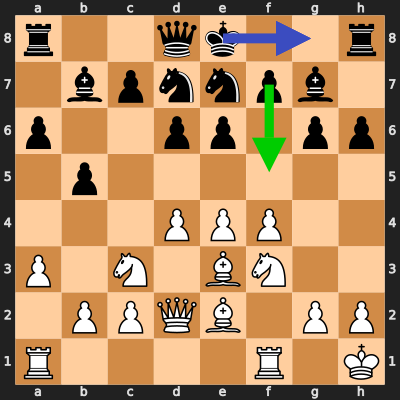

,Source,Puzzle_ID,FEN,Move,Move_UCI,Model,Predicted_Move,wp,cp,acierto,wp_stockfish,wp_best_stockfish,perdida_wp,acierto_stockfish,acierto_combinado
1310,SBP_HARD,148SBPH,r2qk2r/1bpnnpb1/p2pp1pp/1p6/3PPP2/P1N1BN2/1PPQ...,f5,f7f5,136M_results,e8g8,0.503795,4.0,False,0.511964,0.46691,-0.045055,False,Ninguno acierta
1311,SBP_HARD,148SBPH,r2qk2r/1bpnnpb1/p2pp1pp/1p6/3PPP2/P1N1BN2/1PPQ...,f5,f7f5,270M_results,e8g8,0.510810,11.0,False,0.511964,0.46691,-0.045055,False,Ninguno acierta
1312,SBP_HARD,148SBPH,r2qk2r/1bpnnpb1/p2pp1pp/1p6/3PPP2/P1N1BN2/1PPQ...,f5,f7f5,9M_results,e8g8,0.505194,5.0,False,0.511964,0.46691,-0.045055,False,Ninguno acierta
1313,SBP_HARD,148SBPH,r2qk2r/1bpnnpb1/p2pp1pp/1p6/3PPP2/P1N1BN2/1PPQ...,f5,f7f5,stockfish_all_moves_results,e8g8,0.522078,24.0,False,0.511964,0.46691,-0.045055,False,Ninguno acierta
1314,SBP_HARD,148SBPH,r2qk2r/1bpnnpb1/p2pp1pp/1p6/3PPP2/P1N1BN2/1PPQ...,f5,f7f5,stockfish_all_moves_results_20depth,e8g8,0.511964,13.0,False,0.511964,0.46691,-0.045055,False,Ninguno acierta


Puzzle ID: 274SBPH


/tmp/ipykernel_2465481/1499181793.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("coolwarm")  # o "Reds", "YlOrRd", etc.


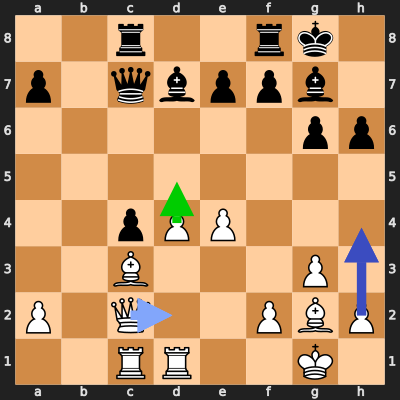

,Source,Puzzle_ID,FEN,Move,Move_UCI,Model,Predicted_Move,wp,cp,acierto,wp_stockfish,wp_best_stockfish,perdida_wp,acierto_stockfish,acierto_combinado
2010,SBP_HARD,274SBPH,2r2rk1/p1qbppb1/6pp/8/2pPP3/2B3P1/P1Q2PBP/2RR2...,d5,d4d5,136M_results,c2d2,0.567372,73.0,False,0.543157,0.563176,0.020020,False,Ninguno acierta
2011,SBP_HARD,274SBPH,2r2rk1/p1qbppb1/6pp/8/2pPP3/2B3P1/P1Q2PBP/2RR2...,d5,d4d5,270M_results,c2d2,0.572027,78.0,False,0.543157,0.563176,0.020020,False,Ninguno acierta
2012,SBP_HARD,274SBPH,2r2rk1/p1qbppb1/6pp/8/2pPP3/2B3P1/P1Q2PBP/2RR2...,d5,d4d5,9M_results,c2d2,0.551578,56.0,False,0.543157,0.563176,0.020020,False,Ninguno acierta
2013,SBP_HARD,274SBPH,2r2rk1/p1qbppb1/6pp/8/2pPP3/2B3P1/P1Q2PBP/2RR2...,d5,d4d5,stockfish_all_moves_results,h2h4,0.560457,66.0,False,0.565892,0.563176,-0.002716,False,Ninguno acierta
2014,SBP_HARD,274SBPH,2r2rk1/p1qbppb1/6pp/8/2pPP3/2B3P1/P1Q2PBP/2RR2...,d5,d4d5,stockfish_all_moves_results_20depth,h2h4,0.565892,72.0,False,0.565892,0.563176,-0.002716,False,Ninguno acierta


Puzzle ID: 250SBPH


/tmp/ipykernel_2465481/1499181793.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("coolwarm")  # o "Reds", "YlOrRd", etc.


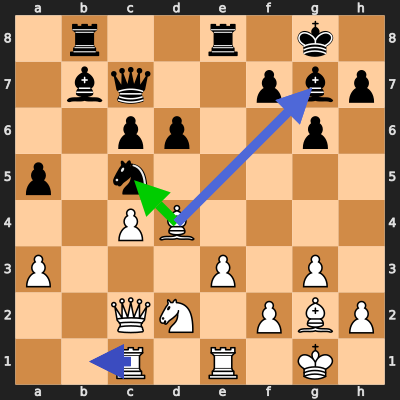

,Source,Puzzle_ID,FEN,Move,Move_UCI,Model,Predicted_Move,wp,cp,acierto,wp_stockfish,wp_best_stockfish,perdida_wp,acierto_stockfish,acierto_combinado
1880,SBP_HARD,250SBPH,1r2r1k1/1bq2pbp/2pp2p1/p1n5/2PB4/P3P1P1/2QN1PB...,Bxc5,d4c5,136M_results,c1b1,0.568142,74.0,False,0.563176,0.534007,-0.029170,False,Ninguno acierta
1881,SBP_HARD,250SBPH,1r2r1k1/1bq2pbp/2pp2p1/p1n5/2PB4/P3P1P1/2QN1PB...,Bxc5,d4c5,270M_results,c1b1,0.569652,76.0,False,0.563176,0.534007,-0.029170,False,Ninguno acierta
1882,SBP_HARD,250SBPH,1r2r1k1/1bq2pbp/2pp2p1/p1n5/2PB4/P3P1P1/2QN1PB...,Bxc5,d4c5,9M_results,d4g7,0.552861,57.0,False,0.555008,0.534007,-0.021001,False,Ninguno acierta
1883,SBP_HARD,250SBPH,1r2r1k1/1bq2pbp/2pp2p1/p1n5/2PB4/P3P1P1/2QN1PB...,Bxc5,d4c5,stockfish_all_moves_results,d4g7,0.560457,66.0,False,0.555008,0.534007,-0.021001,False,Ninguno acierta
1884,SBP_HARD,250SBPH,1r2r1k1/1bq2pbp/2pp2p1/p1n5/2PB4/P3P1P1/2QN1PB...,Bxc5,d4c5,stockfish_all_moves_results_20depth,c1b1,0.563176,69.0,False,0.563176,0.534007,-0.029170,False,Ninguno acierta


Puzzle ID: 201CBP


/tmp/ipykernel_2465481/1499181793.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("coolwarm")  # o "Reds", "YlOrRd", etc.


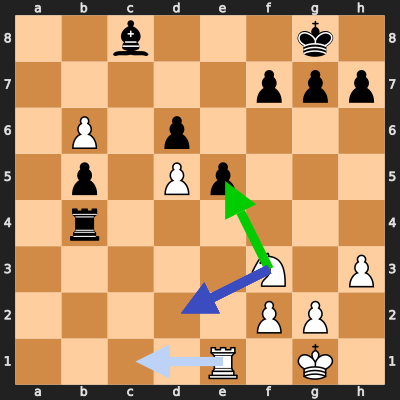

,Source,Puzzle_ID,FEN,Move,Move_UCI,Model,Predicted_Move,wp,cp,acierto,wp_stockfish,wp_best_stockfish,perdida_wp,acierto_stockfish,acierto_combinado
995,CBP_HARD,201CBP,2b3k1/5ppp/1P1p4/1p1Pp3/1r6/5N1P/5PP1/4R1K1 w ...,Nxe5,f3e5,136M_results,f3d2,0.568024,74.0,False,0.597241,0.498159,-0.099082,False,Ninguno acierta
996,CBP_HARD,201CBP,2b3k1/5ppp/1P1p4/1p1Pp3/1r6/5N1P/5PP1/4R1K1 w ...,Nxe5,f3e5,270M_results,f3d2,0.554142,59.0,False,0.597241,0.498159,-0.099082,False,Ninguno acierta
997,CBP_HARD,201CBP,2b3k1/5ppp/1P1p4/1p1Pp3/1r6/5N1P/5PP1/4R1K1 w ...,Nxe5,f3e5,9M_results,e1c1,0.513555,14.0,False,0.520240,0.498159,-0.022081,False,Ninguno acierta
998,CBP_HARD,201CBP,2b3k1/5ppp/1P1p4/1p1Pp3/1r6/5N1P/5PP1/4R1K1 w ...,Nxe5,f3e5,stockfish_all_moves_results,f3d2,0.580304,88.0,False,0.597241,0.498159,-0.099082,False,Ninguno acierta
999,CBP_HARD,201CBP,2b3k1/5ppp/1P1p4/1p1Pp3/1r6/5N1P/5PP1/4R1K1 w ...,Nxe5,f3e5,stockfish_all_moves_results_20depth,f3d2,0.597241,107.0,False,0.597241,0.498159,-0.099082,False,Ninguno acierta


Puzzle ID: 166CBP


/tmp/ipykernel_2465481/1499181793.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("coolwarm")  # o "Reds", "YlOrRd", etc.


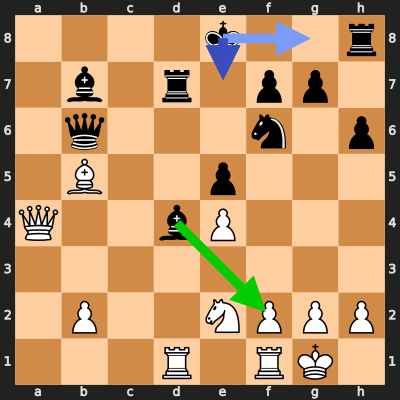

,Source,Puzzle_ID,FEN,Move,Move_UCI,Model,Predicted_Move,wp,cp,acierto,wp_stockfish,wp_best_stockfish,perdida_wp,acierto_stockfish,acierto_combinado
825,CBP_HARD,166CBP,4k2r/1b1r1pp1/1q3n1p/1B2p3/Q2bP3/8/1P2NPPP/3R1...,Bxf2+,d4f2,136M_results,e8g8,0.495932,-4.0,False,0.500000,0.5,0.000000,False,Ninguno acierta
826,CBP_HARD,166CBP,4k2r/1b1r1pp1/1q3n1p/1B2p3/Q2bP3/8/1P2NPPP/3R1...,Bxf2+,d4f2,270M_results,e8e7,0.473689,-28.0,False,0.523915,0.5,-0.023915,False,Ninguno acierta
827,CBP_HARD,166CBP,4k2r/1b1r1pp1/1q3n1p/1B2p3/Q2bP3/8/1P2NPPP/3R1...,Bxf2+,d4f2,9M_results,e8g8,0.569910,76.0,False,0.500000,0.5,0.000000,False,Ninguno acierta
828,CBP_HARD,166CBP,4k2r/1b1r1pp1/1q3n1p/1B2p3/Q2bP3/8/1P2NPPP/3R1...,Bxf2+,d4f2,stockfish_all_moves_results,e8e7,0.526670,29.0,False,0.523915,0.5,-0.023915,False,Ninguno acierta
829,CBP_HARD,166CBP,4k2r/1b1r1pp1/1q3n1p/1B2p3/Q2bP3/8/1P2NPPP/3R1...,Bxf2+,d4f2,stockfish_all_moves_results_20depth,e8e7,0.523915,26.0,False,0.523915,0.5,-0.023915,False,Ninguno acierta


Puzzle ID: 75SBPH


/tmp/ipykernel_2465481/1499181793.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("coolwarm")  # o "Reds", "YlOrRd", etc.


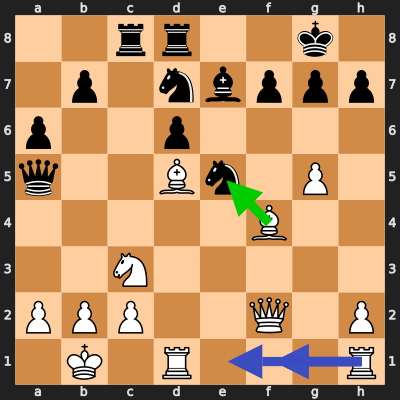

,Source,Puzzle_ID,FEN,Move,Move_UCI,Model,Predicted_Move,wp,cp,acierto,wp_stockfish,wp_best_stockfish,perdida_wp,acierto_stockfish,acierto_combinado
2835,SBP_HARD,75SBPH,2rr2k1/1p1nbppp/p2p4/q2Bn1P1/5B2/2N5/PPP2Q1P/1...,Bxe5,f4e5,136M_results,h1f1,0.685242,211.0,False,0.676212,0.659056,-0.017155,False,Ninguno acierta
2836,SBP_HARD,75SBPH,2rr2k1/1p1nbppp/p2p4/q2Bn1P1/5B2/2N5/PPP2Q1P/1...,Bxe5,f4e5,270M_results,h1f1,0.681482,206.0,False,0.676212,0.659056,-0.017155,False,Ninguno acierta
2837,SBP_HARD,75SBPH,2rr2k1/1p1nbppp/p2p4/q2Bn1P1/5B2/2N5/PPP2Q1P/1...,Bxe5,f4e5,9M_results,h1f1,0.676243,200.0,False,0.676212,0.659056,-0.017155,False,Ninguno acierta
2838,SBP_HARD,75SBPH,2rr2k1/1p1nbppp/p2p4/q2Bn1P1/5B2/2N5/PPP2Q1P/1...,Bxe5,f4e5,stockfish_all_moves_results,h1f1,0.696809,226.0,False,0.676212,0.659056,-0.017155,False,Ninguno acierta
2839,SBP_HARD,75SBPH,2rr2k1/1p1nbppp/p2p4/q2Bn1P1/5B2/2N5/PPP2Q1P/1...,Bxe5,f4e5,stockfish_all_moves_results_20depth,h1e1,0.677017,201.0,False,0.677017,0.659056,-0.017961,False,Ninguno acierta


Puzzle ID: 77SBPH


/tmp/ipykernel_2465481/1499181793.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("coolwarm")  # o "Reds", "YlOrRd", etc.


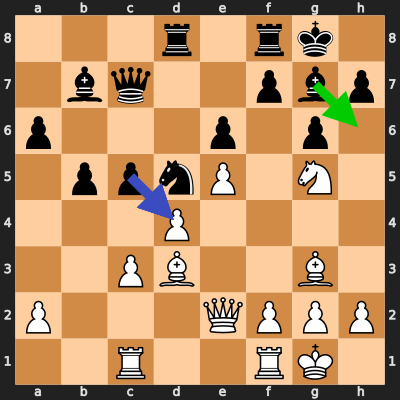

,Source,Puzzle_ID,FEN,Move,Move_UCI,Model,Predicted_Move,wp,cp,acierto,wp_stockfish,wp_best_stockfish,perdida_wp,acierto_stockfish,acierto_combinado
2845,SBP_HARD,77SBPH,3r1rk1/1bq2pbp/p3p1p1/1ppnP1N1/3P4/2PB2B1/P3QP...,Bh6,g7h6,136M_results,c5d4,0.587521,96.0,False,0.661534,0.6087,-0.052835,False,Ninguno acierta
2846,SBP_HARD,77SBPH,3r1rk1/1bq2pbp/p3p1p1/1ppnP1N1/3P4/2PB2B1/P3QP...,Bh6,g7h6,270M_results,c5d4,0.599667,109.0,False,0.661534,0.6087,-0.052835,False,Ninguno acierta
2847,SBP_HARD,77SBPH,3r1rk1/1bq2pbp/p3p1p1/1ppnP1N1/3P4/2PB2B1/P3QP...,Bh6,g7h6,9M_results,c5d4,0.588897,97.0,False,0.661534,0.6087,-0.052835,False,Ninguno acierta
2848,SBP_HARD,77SBPH,3r1rk1/1bq2pbp/p3p1p1/1ppnP1N1/3P4/2PB2B1/P3QP...,Bh6,g7h6,stockfish_all_moves_results,c5d4,0.643166,160.0,False,0.661534,0.6087,-0.052835,False,Ninguno acierta
2849,SBP_HARD,77SBPH,3r1rk1/1bq2pbp/p3p1p1/1ppnP1N1/3P4/2PB2B1/P3QP...,Bh6,g7h6,stockfish_all_moves_results_20depth,c5d4,0.661534,182.0,False,0.661534,0.6087,-0.052835,False,Ninguno acierta


In [49]:
for puzzle_idx in problemas_fallados_por_todos.index:
    analiza_problema(puzzle_idx)
    

Según podemos ver en las figuras anteriores, apenas hay fallos a criterio de Stockfish: de hecho, normalmente, las jugadas propuestas por los algoritmos suelen tener mejor valoración que la propia mejor jugada. Además, cuando suceden fallos más significativos, solamente los reporta el modelo 9M (siendo destacable el problema 004CBP, donde comete un error grave de un 30% de pérdida). Por tanto, llegamos a la conclusión de que dichas posiciones realmente se pueden jugar de varias maneras sin incurrir en una pérdida significativa de probabilidad de victoria. Sin embargo, es probable que las jugadas propuestas por los algoritmos no estén alineadas con una forma humana de jugar la posición e impliquen variantes muy complejas.

### Mayores desalineamientos

En este apartado, veremos donde los modelos han jugado movimientos creyendo que son buenos mientras que eran errores. De esta manera, buscamos errores optimistas de nuestros modelos.

In [50]:
df_grafico['error_alineamiento'] = df_grafico['wp'] - df_grafico['wp_stockfish']

In [51]:
df_desalineamiento_9M = df_grafico[df_grafico['Model'] == '9M_results'].sort_values(by='error_alineamiento', ascending=False).head(10)
print(df_desalineamiento_9M)

       Source Puzzle_ID                                                FEN  Move Move_UCI       Model Predicted_Move        wp     cp  acierto  wp_stockfish  wp_best_stockfish  perdida_wp  acierto_stockfish  acierto_combinado  error_alineamiento
942  CBP_HARD    190CBP  r2q3r/1p1bbQ2/4p1Bk/3pP3/1n1P1P2/pP4p1/Pn5P/R1...    h4     h2h4  9M_results           f4f5  0.886013  556.0    False      0.256523           0.907450    0.650927               True  Acierta Stockfish            0.629490
47   CBP_HARD    010CBP  2r3r1/p1q2p1k/1p1p1p1p/n3pP2/3PPN1Q/P4R2/6PP/R...   Qc4     c7c4  9M_results           e5f4  0.671369  194.0    False      0.110294           0.739241    0.628947               True  Acierta Stockfish            0.561075
317  CBP_HARD    064CBP  2Rb2k1/3q1rpp/p3Q3/2N1p3/4P3/3Pp3/1P4PP/1K6 b ...  Qxc8     d7c8  9M_results           d7e6  0.640281  156.0    False      0.087132           0.500000    0.412868               True  Acierta Stockfish            0.553149
542  CBP_HARD   

In [52]:
df_desalineamiento_136M = df_grafico[df_grafico['Model'] == '136M_results'].sort_values(by='error_alineamiento', ascending=False).head(10)
print(df_desalineamiento_136M)

        Source Puzzle_ID                                                FEN  Move Move_UCI         Model Predicted_Move        wp     cp  acierto  wp_stockfish  wp_best_stockfish  perdida_wp  acierto_stockfish  acierto_combinado  error_alineamiento
1955  SBP_HARD   264SBPH  2r3k1/pp3ppp/3p1bn1/P2P4/1PP2q2/3QRN2/6PP/1B5K...   Kf8     g8f8  136M_results           f4c4  0.647930  165.0    False      0.189888           0.618303    0.428415               True  Acierta Stockfish            0.458042
755   CBP_HARD    152CBP  r2q1rk1/pb2bppp/1p2p3/6PQ/2P1p1N1/1n1PP3/1B3P1...  exd3     e4d3  136M_results           e7g5  0.687255  213.0    False      0.273736           0.771198    0.497462               True  Acierta Stockfish            0.413519
2435  SBP_HARD   350SBPH   1q3rk1/5ppp/3P4/Q7/1p6/6P1/b4PBP/2R3K1 b - - 0 1   Be6     a2e6  136M_results           b4b3  0.621713  134.0    False      0.208678           0.498159    0.289481               True  Acierta Stockfish            0.413035
965 

In [53]:
df_desalineamiento_270M = df_grafico[df_grafico['Model'] == '270M_results'].sort_values(by='error_alineamiento', ascending=False).head(10)
print(df_desalineamiento_270M)

        Source Puzzle_ID                                                FEN   Move Move_UCI         Model Predicted_Move        wp     cp  acierto  wp_stockfish  wp_best_stockfish  perdida_wp  acierto_stockfish  acierto_combinado  error_alineamiento
941   CBP_HARD    190CBP  r2q3r/1p1bbQ2/4p1Bk/3pP3/1n1P1P2/pP4p1/Pn5P/R1...     h4     h2h4  270M_results           f4f5  0.614333  126.0    False      0.256523           0.907450    0.650927               True  Acierta Stockfish            0.357811
541   CBP_HARD    109CBP  1r6/2q1k2p/1P3nr1/2p1bQ2/R1B5/4p2P/1P4P1/3R3K ...     e2     e3e2  270M_results           b8b6  0.413947  -94.0    False      0.079005           0.500000    0.420995               True  Acierta Stockfish            0.334942
631   CBP_HARD    127CBP  1n1q1r1k/4r1p1/pp2p1B1/3p2b1/2P1Q3/3R2P1/PP2PP...    Qe8     d8e8  270M_results           d5e4  0.492790   -7.0    False      0.204454           0.691337    0.486883               True  Acierta Stockfish            0.288337


In [54]:
df_desalineamiento = pd.concat([df_desalineamiento_9M, df_desalineamiento_136M, df_desalineamiento_270M])

Numero de puzzles: 25
Puzzle ID: 190CBP


/tmp/ipykernel_2465481/1499181793.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("coolwarm")  # o "Reds", "YlOrRd", etc.


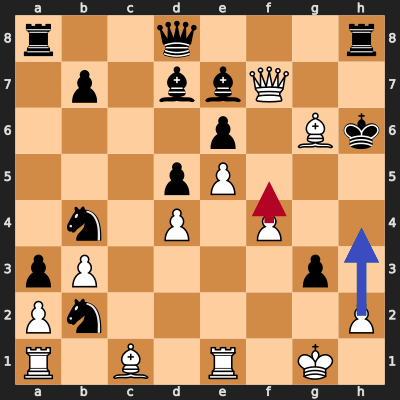

,Source,Puzzle_ID,FEN,Move,Move_UCI,Model,Predicted_Move,wp,cp,acierto,wp_stockfish,wp_best_stockfish,perdida_wp,acierto_stockfish,acierto_combinado,error_alineamiento
940,CBP_HARD,190CBP,r2q3r/1p1bbQ2/4p1Bk/3pP3/1n1P1P2/pP4p1/Pn5P/R1...,h4,h2h4,136M_results,h2h4,0.640140,156.0,True,0.907450,0.90745,0.000000,True,Ambos aciertan,-0.267310
941,CBP_HARD,190CBP,r2q3r/1p1bbQ2/4p1Bk/3pP3/1n1P1P2/pP4p1/Pn5P/R1...,h4,h2h4,270M_results,f4f5,0.614333,126.0,False,0.256523,0.90745,0.650927,True,Acierta Stockfish,0.357811
942,CBP_HARD,190CBP,r2q3r/1p1bbQ2/4p1Bk/3pP3/1n1P1P2/pP4p1/Pn5P/R1...,h4,h2h4,9M_results,f4f5,0.886013,556.0,False,0.256523,0.90745,0.650927,True,Acierta Stockfish,0.629490
943,CBP_HARD,190CBP,r2q3r/1p1bbQ2/4p1Bk/3pP3/1n1P1P2/pP4p1/Pn5P/R1...,h4,h2h4,stockfish_all_moves_results,h2h4,0.607822,119.0,True,0.907450,0.90745,0.000000,True,Ambos aciertan,-0.299628
944,CBP_HARD,190CBP,r2q3r/1p1bbQ2/4p1Bk/3pP3/1n1P1P2/pP4p1/Pn5P/R1...,h4,h2h4,stockfish_all_moves_results_20depth,h2h4,0.907450,620.0,True,0.907450,0.90745,0.000000,True,Ambos aciertan,0.000000


Puzzle ID: 010CBP


/tmp/ipykernel_2465481/1499181793.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("coolwarm")  # o "Reds", "YlOrRd", etc.


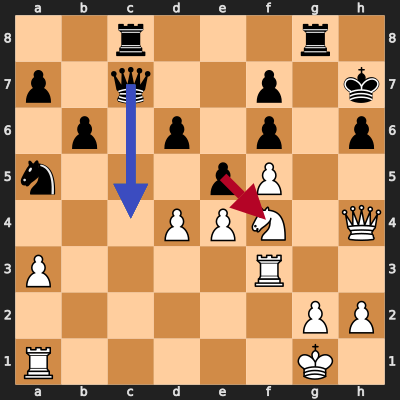

,Source,Puzzle_ID,FEN,Move,Move_UCI,Model,Predicted_Move,wp,cp,acierto,wp_stockfish,wp_best_stockfish,perdida_wp,acierto_stockfish,acierto_combinado,error_alineamiento
45,CBP_HARD,010CBP,2r3r1/p1q2p1k/1p1p1p1p/n3pP2/3PPN1Q/P4R2/6PP/R...,Qc4,c7c4,136M_results,c7c4,0.588682,97.0,True,0.739241,0.739241,0.000000,True,Ambos aciertan,-0.150559
46,CBP_HARD,010CBP,2r3r1/p1q2p1k/1p1p1p1p/n3pP2/3PPN1Q/P4R2/6PP/R...,Qc4,c7c4,270M_results,c7c4,0.665825,187.0,True,0.739241,0.739241,0.000000,True,Ambos aciertan,-0.073417
47,CBP_HARD,010CBP,2r3r1/p1q2p1k/1p1p1p1p/n3pP2/3PPN1Q/P4R2/6PP/R...,Qc4,c7c4,9M_results,e5f4,0.671369,194.0,False,0.110294,0.739241,0.628947,True,Acierta Stockfish,0.561075
48,CBP_HARD,010CBP,2r3r1/p1q2p1k/1p1p1p1p/n3pP2/3PPN1Q/P4R2/6PP/R...,Qc4,c7c4,stockfish_all_moves_results,c7c4,0.700685,231.0,True,0.739241,0.739241,0.000000,True,Ambos aciertan,-0.038557
49,CBP_HARD,010CBP,2r3r1/p1q2p1k/1p1p1p1p/n3pP2/3PPN1Q/P4R2/6PP/R...,Qc4,c7c4,stockfish_all_moves_results_20depth,c7c4,0.739241,283.0,True,0.739241,0.739241,0.000000,True,Ambos aciertan,0.000000


Puzzle ID: 064CBP


/tmp/ipykernel_2465481/1499181793.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("coolwarm")  # o "Reds", "YlOrRd", etc.


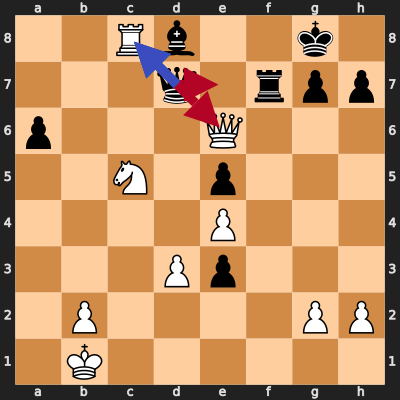

,Source,Puzzle_ID,FEN,Move,Move_UCI,Model,Predicted_Move,wp,cp,acierto,wp_stockfish,wp_best_stockfish,perdida_wp,acierto_stockfish,acierto_combinado,error_alineamiento
315,CBP_HARD,064CBP,2Rb2k1/3q1rpp/p3Q3/2N1p3/4P3/3Pp3/1P4PP/1K6 b ...,Qxc8,d7c8,136M_results,d7c8,0.341666,-178.0,True,0.500000,0.5,0.000000,True,Ambos aciertan,-0.158334
316,CBP_HARD,064CBP,2Rb2k1/3q1rpp/p3Q3/2N1p3/4P3/3Pp3/1P4PP/1K6 b ...,Qxc8,d7c8,270M_results,d7e7,0.348926,-169.0,False,0.124791,0.5,0.375209,True,Acierta Stockfish,0.224135
317,CBP_HARD,064CBP,2Rb2k1/3q1rpp/p3Q3/2N1p3/4P3/3Pp3/1P4PP/1K6 b ...,Qxc8,d7c8,9M_results,d7e6,0.640281,156.0,False,0.087132,0.5,0.412868,True,Acierta Stockfish,0.553149
318,CBP_HARD,064CBP,2Rb2k1/3q1rpp/p3Q3/2N1p3/4P3/3Pp3/1P4PP/1K6 b ...,Qxc8,d7c8,stockfish_all_moves_results,d7c8,0.500000,0.0,True,0.500000,0.5,0.000000,True,Ambos aciertan,0.000000
319,CBP_HARD,064CBP,2Rb2k1/3q1rpp/p3Q3/2N1p3/4P3/3Pp3/1P4PP/1K6 b ...,Qxc8,d7c8,stockfish_all_moves_results_20depth,d7c8,0.500000,0.0,True,0.500000,0.5,0.000000,True,Ambos aciertan,0.000000


Puzzle ID: 109CBP


/tmp/ipykernel_2465481/1499181793.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("coolwarm")  # o "Reds", "YlOrRd", etc.


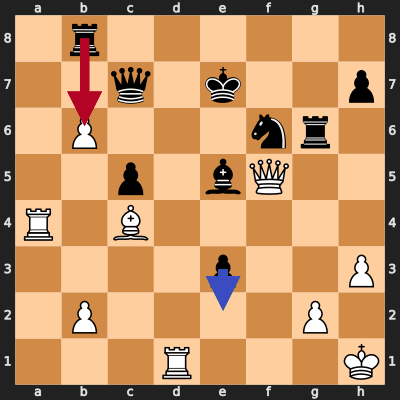

,Source,Puzzle_ID,FEN,Move,Move_UCI,Model,Predicted_Move,wp,cp,acierto,wp_stockfish,wp_best_stockfish,perdida_wp,acierto_stockfish,acierto_combinado,error_alineamiento
540,CBP_HARD,109CBP,1r6/2q1k2p/1P3nr1/2p1bQ2/R1B5/4p2P/1P4P1/3R3K ...,e2,e3e2,136M_results,b8b6,0.422381,-85.0,False,0.079005,0.5,0.420995,True,Acierta Stockfish,0.343376
541,CBP_HARD,109CBP,1r6/2q1k2p/1P3nr1/2p1bQ2/R1B5/4p2P/1P4P1/3R3K ...,e2,e3e2,270M_results,b8b6,0.413947,-94.0,False,0.079005,0.5,0.420995,True,Acierta Stockfish,0.334942
542,CBP_HARD,109CBP,1r6/2q1k2p/1P3nr1/2p1bQ2/R1B5/4p2P/1P4P1/3R3K ...,e2,e3e2,9M_results,b8b6,0.624946,138.0,False,0.079005,0.5,0.420995,True,Acierta Stockfish,0.545941
543,CBP_HARD,109CBP,1r6/2q1k2p/1P3nr1/2p1bQ2/R1B5/4p2P/1P4P1/3R3K ...,e2,e3e2,stockfish_all_moves_results,e3e2,0.500000,0.0,True,0.500000,0.5,0.000000,True,Ambos aciertan,0.000000
544,CBP_HARD,109CBP,1r6/2q1k2p/1P3nr1/2p1bQ2/R1B5/4p2P/1P4P1/3R3K ...,e2,e3e2,stockfish_all_moves_results_20depth,e3e2,0.500000,0.0,True,0.500000,0.5,0.000000,True,Ambos aciertan,0.000000


Puzzle ID: 089CBP


/tmp/ipykernel_2465481/1499181793.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("coolwarm")  # o "Reds", "YlOrRd", etc.


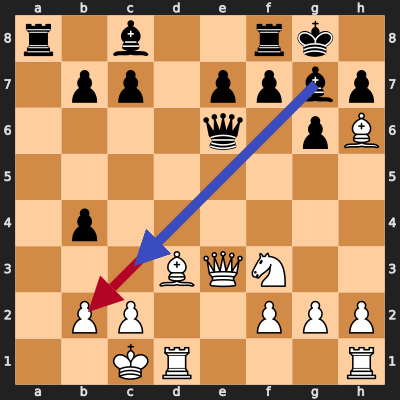

,Source,Puzzle_ID,FEN,Move,Move_UCI,Model,Predicted_Move,wp,cp,acierto,wp_stockfish,wp_best_stockfish,perdida_wp,acierto_stockfish,acierto_combinado,error_alineamiento
440,CBP_HARD,089CBP,r1b2rk1/1pp1ppbp/4q1pB/8/1p6/3BQN2/1PP2PPP/2KR...,Bc3,g7c3,136M_results,g7c3,0.717601,253.0,True,0.637229,0.637229,0.000000,True,Ambos aciertan,0.080371
441,CBP_HARD,089CBP,r1b2rk1/1pp1ppbp/4q1pB/8/1p6/3BQN2/1PP2PPP/2KR...,Bc3,g7c3,270M_results,g7c3,0.748792,296.0,True,0.637229,0.637229,0.000000,True,Ambos aciertan,0.111563
442,CBP_HARD,089CBP,r1b2rk1/1pp1ppbp/4q1pB/8/1p6/3BQN2/1PP2PPP/2KR...,Bc3,g7c3,9M_results,g7b2,0.662961,183.0,False,0.141786,0.637229,0.495444,True,Acierta Stockfish,0.521175
443,CBP_HARD,089CBP,r1b2rk1/1pp1ppbp/4q1pB/8/1p6/3BQN2/1PP2PPP/2KR...,Bc3,g7c3,stockfish_all_moves_results,g7c3,0.588353,97.0,True,0.637229,0.637229,0.000000,True,Ambos aciertan,-0.048876
444,CBP_HARD,089CBP,r1b2rk1/1pp1ppbp/4q1pB/8/1p6/3BQN2/1PP2PPP/2KR...,Bc3,g7c3,stockfish_all_moves_results_20depth,g7c3,0.637229,153.0,True,0.637229,0.637229,0.000000,True,Ambos aciertan,0.000000


Puzzle ID: 112CBP


/tmp/ipykernel_2465481/1499181793.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("coolwarm")  # o "Reds", "YlOrRd", etc.


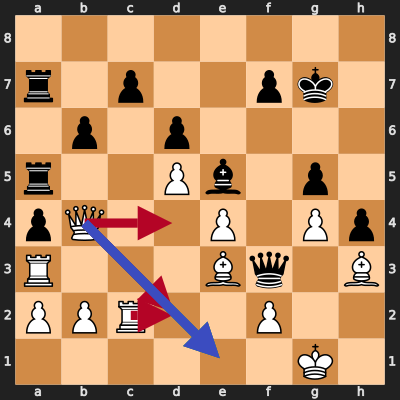

,Source,Puzzle_ID,FEN,Move,Move_UCI,Model,Predicted_Move,wp,cp,acierto,wp_stockfish,wp_best_stockfish,perdida_wp,acierto_stockfish,acierto_combinado,error_alineamiento
555,CBP_HARD,112CBP,8/r1p2pk1/1p1p4/r2Pb1p1/pQ2P1Pp/R3Bq1B/PPR2P2/...,Qe1,b4e1,136M_results,c2d2,0.436503,-69.0,False,0.376497,0.744179,0.367682,True,Acierta Stockfish,0.060006
556,CBP_HARD,112CBP,8/r1p2pk1/1p1p4/r2Pb1p1/pQ2P1Pp/R3Bq1B/PPR2P2/...,Qe1,b4e1,270M_results,b4d2,0.385125,-127.0,False,0.330271,0.744179,0.413908,True,Acierta Stockfish,0.054854
557,CBP_HARD,112CBP,8/r1p2pk1/1p1p4/r2Pb1p1/pQ2P1Pp/R3Bq1B/PPR2P2/...,Qe1,b4e1,9M_results,b4d4,0.616575,129.0,False,0.165697,0.744179,0.578482,True,Acierta Stockfish,0.450878
558,CBP_HARD,112CBP,8/r1p2pk1/1p1p4/r2Pb1p1/pQ2P1Pp/R3Bq1B/PPR2P2/...,Qe1,b4e1,stockfish_all_moves_results,b4e1,0.683425,209.0,True,0.744179,0.744179,0.000000,True,Ambos aciertan,-0.060754
559,CBP_HARD,112CBP,8/r1p2pk1/1p1p4/r2Pb1p1/pQ2P1Pp/R3Bq1B/PPR2P2/...,Qe1,b4e1,stockfish_all_moves_results_20depth,b4e1,0.744179,290.0,True,0.744179,0.744179,0.000000,True,Ambos aciertan,0.000000


Puzzle ID: 027CBP


/tmp/ipykernel_2465481/1499181793.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("coolwarm")  # o "Reds", "YlOrRd", etc.


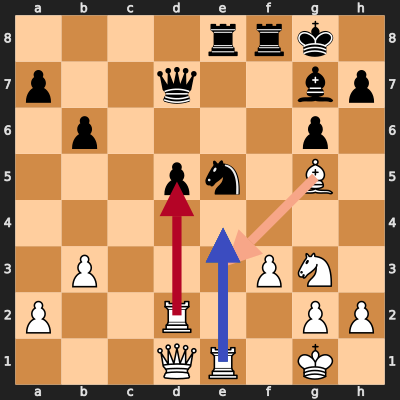

,Source,Puzzle_ID,FEN,Move,Move_UCI,Model,Predicted_Move,wp,cp,acierto,wp_stockfish,wp_best_stockfish,perdida_wp,acierto_stockfish,acierto_combinado,error_alineamiento
130,CBP_HARD,027CBP,4rrk1/p2q2bp/1p4p1/3pn1B1/8/1P3PN1/P2R2PP/3QR1...,Re4,e1e4,136M_results,g5e3,0.566410,72.0,False,0.514724,0.693689,0.178965,True,Acierta Stockfish,0.051686
131,CBP_HARD,027CBP,4rrk1/p2q2bp/1p4p1/3pn1B1/8/1P3PN1/P2R2PP/3QR1...,Re4,e1e4,270M_results,e1e4,0.611639,123.0,True,0.693689,0.693689,0.000000,True,Ambos aciertan,-0.082050
132,CBP_HARD,027CBP,4rrk1/p2q2bp/1p4p1/3pn1B1/8/1P3PN1/P2R2PP/3QR1...,Re4,e1e4,9M_results,d2d5,0.559207,64.0,False,0.124791,0.693689,0.568898,True,Acierta Stockfish,0.434416
133,CBP_HARD,027CBP,4rrk1/p2q2bp/1p4p1/3pn1B1/8/1P3PN1/P2R2PP/3QR1...,Re4,e1e4,stockfish_all_moves_results,e1e4,0.672979,196.0,True,0.693689,0.693689,0.000000,True,Ambos aciertan,-0.020710
134,CBP_HARD,027CBP,4rrk1/p2q2bp/1p4p1/3pn1B1/8/1P3PN1/P2R2PP/3QR1...,Re4,e1e4,stockfish_all_moves_results_20depth,e1e4,0.693689,222.0,True,0.693689,0.693689,0.000000,True,Ambos aciertan,0.000000


Puzzle ID: 136CBP


/tmp/ipykernel_2465481/1499181793.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("coolwarm")  # o "Reds", "YlOrRd", etc.


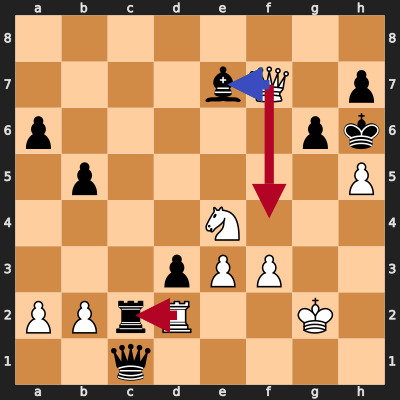

,Source,Puzzle_ID,FEN,Move,Move_UCI,Model,Predicted_Move,wp,cp,acierto,wp_stockfish,wp_best_stockfish,perdida_wp,acierto_stockfish,acierto_combinado,error_alineamiento
675,CBP_HARD,136CBP,8/4bQ1p/p5pk/1p5P/4N3/3pPP2/PPrR2K1/2q5 w - - 0 1,Qxe7,f7e7,136M_results,d2c2,0.561695,67.0,False,0.500000,0.835824,0.335824,True,Acierta Stockfish,0.061695
676,CBP_HARD,136CBP,8/4bQ1p/p5pk/1p5P/4N3/3pPP2/PPrR2K1/2q5 w - - 0 1,Qxe7,f7e7,270M_results,d2c2,0.557359,62.0,False,0.500000,0.835824,0.335824,True,Acierta Stockfish,0.057359
677,CBP_HARD,136CBP,8/4bQ1p/p5pk/1p5P/4N3/3pPP2/PPrR2K1/2q5 w - - 0 1,Qxe7,f7e7,9M_results,f7f4,0.509463,10.0,False,0.096008,0.835824,0.739816,True,Acierta Stockfish,0.413455
678,CBP_HARD,136CBP,8/4bQ1p/p5pk/1p5P/4N3/3pPP2/PPrR2K1/2q5 w - - 0 1,Qxe7,f7e7,stockfish_all_moves_results,f7e7,0.778901,342.0,True,0.835824,0.835824,0.000000,True,Ambos aciertan,-0.056923
679,CBP_HARD,136CBP,8/4bQ1p/p5pk/1p5P/4N3/3pPP2/PPrR2K1/2q5 w - - 0 1,Qxe7,f7e7,stockfish_all_moves_results_20depth,f7e7,0.835824,442.0,True,0.835824,0.835824,0.000000,True,Ambos aciertan,0.000000


Puzzle ID: 195CBP


/tmp/ipykernel_2465481/1499181793.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("coolwarm")  # o "Reds", "YlOrRd", etc.


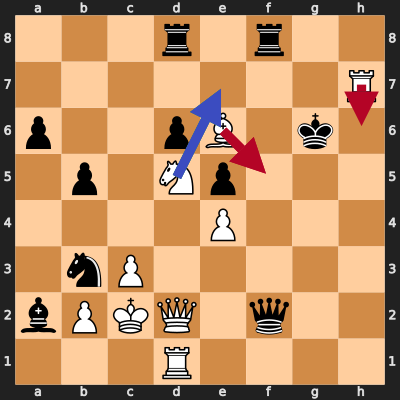

,Source,Puzzle_ID,FEN,Move,Move_UCI,Model,Predicted_Move,wp,cp,acierto,wp_stockfish,wp_best_stockfish,perdida_wp,acierto_stockfish,acierto_combinado,error_alineamiento
965,CBP_HARD,195CBP,3r1r2/7R/p2pB1k1/1p1Np3/4P3/1nP5/bPKQ1q2/3R4 w...,Ne7+,d5e7,136M_results,h7h6,0.645449,162.0,False,0.276673,0.898084,0.621410,True,Acierta Stockfish,0.368775
966,CBP_HARD,195CBP,3r1r2/7R/p2pB1k1/1p1Np3/4P3/1nP5/bPKQ1q2/3R4 w...,Ne7+,d5e7,270M_results,e6f5,0.679923,204.0,False,0.500000,0.898084,0.398084,True,Acierta Stockfish,0.179923
967,CBP_HARD,195CBP,3r1r2/7R/p2pB1k1/1p1Np3/4P3/1nP5/bPKQ1q2/3R4 w...,Ne7+,d5e7,9M_results,e6f5,0.884021,551.0,False,0.500000,0.898084,0.398084,True,Acierta Stockfish,0.384021
968,CBP_HARD,195CBP,3r1r2/7R/p2pB1k1/1p1Np3/4P3/1nP5/bPKQ1q2/3R4 w...,Ne7+,d5e7,stockfish_all_moves_results,d5e7,0.860881,495.0,True,0.898084,0.898084,0.000000,True,Ambos aciertan,-0.037202
969,CBP_HARD,195CBP,3r1r2/7R/p2pB1k1/1p1Np3/4P3/1nP5/bPKQ1q2/3R4 w...,Ne7+,d5e7,stockfish_all_moves_results_20depth,d5e7,0.898084,591.0,True,0.898084,0.898084,0.000000,True,Ambos aciertan,0.000000


Puzzle ID: 175CBP


/tmp/ipykernel_2465481/1499181793.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("coolwarm")  # o "Reds", "YlOrRd", etc.


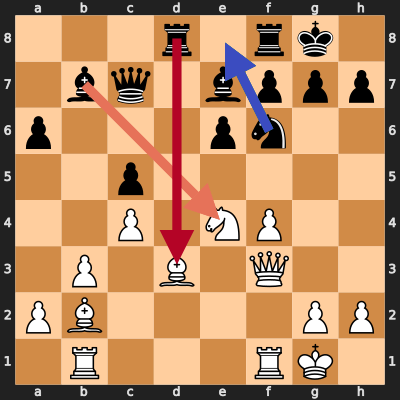

,Source,Puzzle_ID,FEN,Move,Move_UCI,Model,Predicted_Move,wp,cp,acierto,wp_stockfish,wp_best_stockfish,perdida_wp,acierto_stockfish,acierto_combinado,error_alineamiento
870,CBP_HARD,175CBP,3r1rk1/1bq1bppp/p3pn2/2p5/2P1NP2/1P1B1Q2/PB4PP...,Ne8,f6e8,136M_results,b7e4,0.531635,34.0,False,0.500000,0.709868,0.209868,True,Acierta Stockfish,0.031635
871,CBP_HARD,175CBP,3r1rk1/1bq1bppp/p3pn2/2p5/2P1NP2/1P1B1Q2/PB4PP...,Ne8,f6e8,270M_results,b7e4,0.512049,13.0,False,0.500000,0.709868,0.209868,True,Acierta Stockfish,0.012049
872,CBP_HARD,175CBP,3r1rk1/1bq1bppp/p3pn2/2p5/2P1NP2/1P1B1Q2/PB4PP...,Ne8,f6e8,9M_results,d8d3,0.620003,132.0,False,0.264323,0.709868,0.445545,True,Acierta Stockfish,0.355679
873,CBP_HARD,175CBP,3r1rk1/1bq1bppp/p3pn2/2p5/2P1NP2/1P1B1Q2/PB4PP...,Ne8,f6e8,stockfish_all_moves_results,f6e8,0.626954,141.0,True,0.709868,0.709868,0.000000,True,Ambos aciertan,-0.082914
874,CBP_HARD,175CBP,3r1rk1/1bq1bppp/p3pn2/2p5/2P1NP2/1P1B1Q2/PB4PP...,Ne8,f6e8,stockfish_all_moves_results_20depth,f6e8,0.709868,243.0,True,0.709868,0.709868,0.000000,True,Ambos aciertan,0.000000


Puzzle ID: 264SBPH


/tmp/ipykernel_2465481/1499181793.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("coolwarm")  # o "Reds", "YlOrRd", etc.


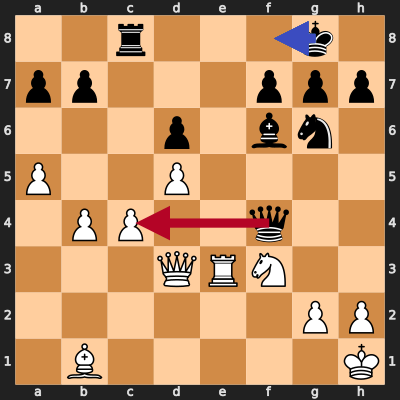

,Source,Puzzle_ID,FEN,Move,Move_UCI,Model,Predicted_Move,wp,cp,acierto,wp_stockfish,wp_best_stockfish,perdida_wp,acierto_stockfish,acierto_combinado,error_alineamiento
1955,SBP_HARD,264SBPH,2r3k1/pp3ppp/3p1bn1/P2P4/1PP2q2/3QRN2/6PP/1B5K...,Kf8,g8f8,136M_results,f4c4,0.647930,165.0,False,0.189888,0.618303,0.428415,True,Acierta Stockfish,0.458042
1956,SBP_HARD,264SBPH,2r3k1/pp3ppp/3p1bn1/P2P4/1PP2q2/3QRN2/6PP/1B5K...,Kf8,g8f8,270M_results,g8f8,0.605906,116.0,True,0.618303,0.618303,0.000000,True,Ambos aciertan,-0.012398
1957,SBP_HARD,264SBPH,2r3k1/pp3ppp/3p1bn1/P2P4/1PP2q2/3QRN2/6PP/1B5K...,Kf8,g8f8,9M_results,g8f8,0.575697,82.0,True,0.618303,0.618303,0.000000,True,Ambos aciertan,-0.042606
1958,SBP_HARD,264SBPH,2r3k1/pp3ppp/3p1bn1/P2P4/1PP2q2/3QRN2/6PP/1B5K...,Kf8,g8f8,stockfish_all_moves_results,g8f8,0.606944,118.0,True,0.618303,0.618303,0.000000,True,Ambos aciertan,-0.011359
1959,SBP_HARD,264SBPH,2r3k1/pp3ppp/3p1bn1/P2P4/1PP2q2/3QRN2/6PP/1B5K...,Kf8,g8f8,stockfish_all_moves_results_20depth,g8f8,0.618303,131.0,True,0.618303,0.618303,0.000000,True,Ambos aciertan,0.000000


Puzzle ID: 152CBP


/tmp/ipykernel_2465481/1499181793.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("coolwarm")  # o "Reds", "YlOrRd", etc.


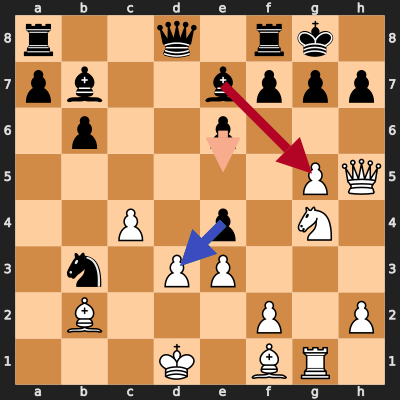

,Source,Puzzle_ID,FEN,Move,Move_UCI,Model,Predicted_Move,wp,cp,acierto,wp_stockfish,wp_best_stockfish,perdida_wp,acierto_stockfish,acierto_combinado,error_alineamiento
755,CBP_HARD,152CBP,r2q1rk1/pb2bppp/1p2p3/6PQ/2P1p1N1/1n1PP3/1B3P1...,exd3,e4d3,136M_results,e7g5,0.687255,213.0,False,0.273736,0.771198,0.497462,True,Acierta Stockfish,0.413519
756,CBP_HARD,152CBP,r2q1rk1/pb2bppp/1p2p3/6PQ/2P1p1N1/1n1PP3/1B3P1...,exd3,e4d3,270M_results,e6e5,0.611104,122.0,False,0.595468,0.771198,0.175729,True,Acierta Stockfish,0.015636
757,CBP_HARD,152CBP,r2q1rk1/pb2bppp/1p2p3/6PQ/2P1p1N1/1n1PP3/1B3P1...,exd3,e4d3,9M_results,e6e5,0.646630,164.0,False,0.595468,0.771198,0.175729,True,Acierta Stockfish,0.051162
758,CBP_HARD,152CBP,r2q1rk1/pb2bppp/1p2p3/6PQ/2P1p1N1/1n1PP3/1B3P1...,exd3,e4d3,stockfish_all_moves_results,e4d3,0.692906,221.0,True,0.771198,0.771198,0.000000,True,Ambos aciertan,-0.078292
759,CBP_HARD,152CBP,r2q1rk1/pb2bppp/1p2p3/6PQ/2P1p1N1/1n1PP3/1B3P1...,exd3,e4d3,stockfish_all_moves_results_20depth,e4d3,0.771198,330.0,True,0.771198,0.771198,0.000000,True,Ambos aciertan,0.000000


Puzzle ID: 350SBPH


/tmp/ipykernel_2465481/1499181793.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("coolwarm")  # o "Reds", "YlOrRd", etc.


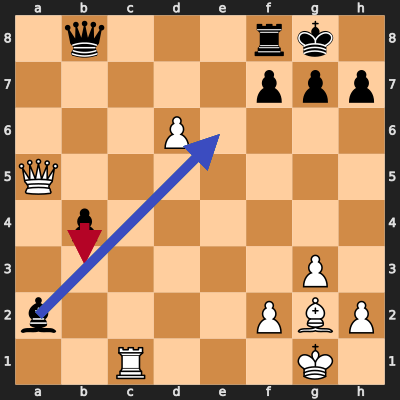

,Source,Puzzle_ID,FEN,Move,Move_UCI,Model,Predicted_Move,wp,cp,acierto,wp_stockfish,wp_best_stockfish,perdida_wp,acierto_stockfish,acierto_combinado,error_alineamiento
2435,SBP_HARD,350SBPH,1q3rk1/5ppp/3P4/Q7/1p6/6P1/b4PBP/2R3K1 b - - 0 1,Be6,a2e6,136M_results,b4b3,0.621713,134.0,False,0.208678,0.498159,0.289481,True,Acierta Stockfish,0.413035
2436,SBP_HARD,350SBPH,1q3rk1/5ppp/3P4/Q7/1p6/6P1/b4PBP/2R3K1 b - - 0 1,Be6,a2e6,270M_results,a2e6,0.518091,19.0,True,0.498159,0.498159,0.000000,True,Ambos aciertan,0.019932
2437,SBP_HARD,350SBPH,1q3rk1/5ppp/3P4/Q7/1p6/6P1/b4PBP/2R3K1 b - - 0 1,Be6,a2e6,9M_results,b4b3,0.551231,55.0,False,0.208678,0.498159,0.289481,True,Acierta Stockfish,0.342553
2438,SBP_HARD,350SBPH,1q3rk1/5ppp/3P4/Q7/1p6/6P1/b4PBP/2R3K1 b - - 0 1,Be6,a2e6,stockfish_all_moves_results,a2e6,0.504602,5.0,True,0.498159,0.498159,0.000000,True,Ambos aciertan,0.006444
2439,SBP_HARD,350SBPH,1q3rk1/5ppp/3P4/Q7/1p6/6P1/b4PBP/2R3K1 b - - 0 1,Be6,a2e6,stockfish_all_moves_results_20depth,a2e6,0.498159,-2.0,True,0.498159,0.498159,0.000000,True,Ambos aciertan,0.000000


Puzzle ID: 161CBP


/tmp/ipykernel_2465481/1499181793.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("coolwarm")  # o "Reds", "YlOrRd", etc.


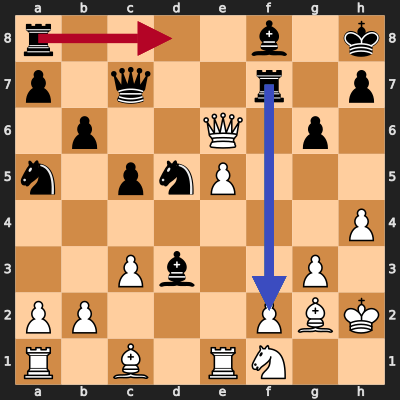

,Source,Puzzle_ID,FEN,Move,Move_UCI,Model,Predicted_Move,wp,cp,acierto,wp_stockfish,wp_best_stockfish,perdida_wp,acierto_stockfish,acierto_combinado,error_alineamiento
800,CBP_HARD,161CBP,r4b1k/p1q2r1p/1p2Q1p1/n1pnP3/7P/2Pb2P1/PP3PBK/...,Rxf2,f7f2,136M_results,a8d8,0.530928,33.0,False,0.191593,0.718884,0.527291,True,Acierta Stockfish,0.339335
801,CBP_HARD,161CBP,r4b1k/p1q2r1p/1p2Q1p1/n1pnP3/7P/2Pb2P1/PP3PBK/...,Rxf2,f7f2,270M_results,f7f2,0.572873,79.0,True,0.718884,0.718884,0.000000,True,Ambos aciertan,-0.146010
802,CBP_HARD,161CBP,r4b1k/p1q2r1p/1p2Q1p1/n1pnP3/7P/2Pb2P1/PP3PBK/...,Rxf2,f7f2,9M_results,a8d8,0.466868,-36.0,False,0.191593,0.718884,0.527291,True,Acierta Stockfish,0.275276
803,CBP_HARD,161CBP,r4b1k/p1q2r1p/1p2Q1p1/n1pnP3/7P/2Pb2P1/PP3PBK/...,Rxf2,f7f2,stockfish_all_moves_results,f7f2,0.641474,158.0,True,0.718884,0.718884,0.000000,True,Ambos aciertan,-0.077409
804,CBP_HARD,161CBP,r4b1k/p1q2r1p/1p2Q1p1/n1pnP3/7P/2Pb2P1/PP3PBK/...,Rxf2,f7f2,stockfish_all_moves_results_20depth,f7f2,0.718884,255.0,True,0.718884,0.718884,0.000000,True,Ambos aciertan,0.000000


Puzzle ID: 111CBP


/tmp/ipykernel_2465481/1499181793.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("coolwarm")  # o "Reds", "YlOrRd", etc.


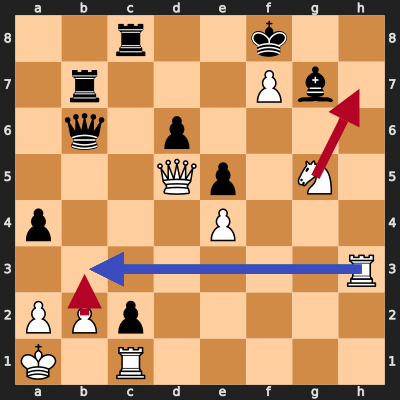

,Source,Puzzle_ID,FEN,Move,Move_UCI,Model,Predicted_Move,wp,cp,acierto,wp_stockfish,wp_best_stockfish,perdida_wp,acierto_stockfish,acierto_combinado,error_alineamiento
550,CBP_HARD,111CBP,2r2k2/1r3Pb1/1q1p4/3Qp1N1/p3P3/7R/PPp5/K1R5 w ...,Rb3,h3b3,136M_results,g5h7,0.517071,18.0,False,0.178277,0.932936,0.754659,True,Acierta Stockfish,0.338794
551,CBP_HARD,111CBP,2r2k2/1r3Pb1/1q1p4/3Qp1N1/p3P3/7R/PPp5/K1R5 w ...,Rb3,h3b3,270M_results,h3b3,0.682683,208.0,True,0.932936,0.932936,0.000000,True,Ambos aciertan,-0.250253
552,CBP_HARD,111CBP,2r2k2/1r3Pb1/1q1p4/3Qp1N1/p3P3/7R/PPp5/K1R5 w ...,Rb3,h3b3,9M_results,b2b3,0.601559,111.0,False,0.494477,0.932936,0.438459,True,Acierta Stockfish,0.107082
553,CBP_HARD,111CBP,2r2k2/1r3Pb1/1q1p4/3Qp1N1/p3P3/7R/PPp5/K1R5 w ...,Rb3,h3b3,stockfish_all_moves_results,h3b3,0.914321,643.0,True,0.932936,0.932936,0.000000,True,Ambos aciertan,-0.018615
554,CBP_HARD,111CBP,2r2k2/1r3Pb1/1q1p4/3Qp1N1/p3P3/7R/PPp5/K1R5 w ...,Rb3,h3b3,stockfish_all_moves_results_20depth,h3b3,0.932936,715.0,True,0.932936,0.932936,0.000000,True,Ambos aciertan,0.000000


Puzzle ID: 060CBP


/tmp/ipykernel_2465481/1499181793.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("coolwarm")  # o "Reds", "YlOrRd", etc.


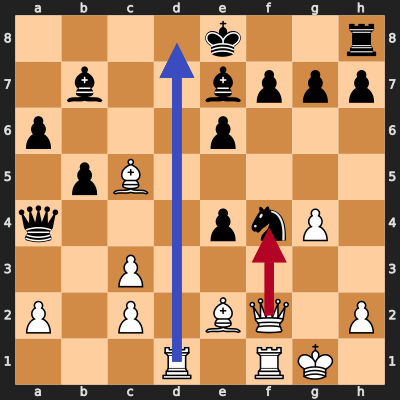

,Source,Puzzle_ID,FEN,Move,Move_UCI,Model,Predicted_Move,wp,cp,acierto,wp_stockfish,wp_best_stockfish,perdida_wp,acierto_stockfish,acierto_combinado,error_alineamiento
295,CBP_HARD,060CBP,4k2r/1b2bppp/p3p3/1pB5/q3pnP1/2P5/P1P1BQ1P/3R1...,Rd8+,d1d8,136M_results,f2f4,0.552842,57.0,False,0.261469,0.645697,0.384228,True,Acierta Stockfish,0.291373
296,CBP_HARD,060CBP,4k2r/1b2bppp/p3p3/1pB5/q3pnP1/2P5/P1P1BQ1P/3R1...,Rd8+,d1d8,270M_results,d1d8,0.399143,-111.0,True,0.645697,0.645697,0.000000,True,Ambos aciertan,-0.246554
297,CBP_HARD,060CBP,4k2r/1b2bppp/p3p3/1pB5/q3pnP1/2P5/P1P1BQ1P/3R1...,Rd8+,d1d8,9M_results,f2f4,0.404480,-105.0,False,0.261469,0.645697,0.384228,True,Acierta Stockfish,0.143011
298,CBP_HARD,060CBP,4k2r/1b2bppp/p3p3/1pB5/q3pnP1/2P5/P1P1BQ1P/3R1...,Rd8+,d1d8,stockfish_all_moves_results,d1d8,0.588353,97.0,True,0.645697,0.645697,0.000000,True,Ambos aciertan,-0.057344
299,CBP_HARD,060CBP,4k2r/1b2bppp/p3p3/1pB5/q3pnP1/2P5/P1P1BQ1P/3R1...,Rd8+,d1d8,stockfish_all_moves_results_20depth,d1d8,0.645697,163.0,True,0.645697,0.645697,0.000000,True,Ambos aciertan,0.000000


Puzzle ID: 176CBP


/tmp/ipykernel_2465481/1499181793.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("coolwarm")  # o "Reds", "YlOrRd", etc.


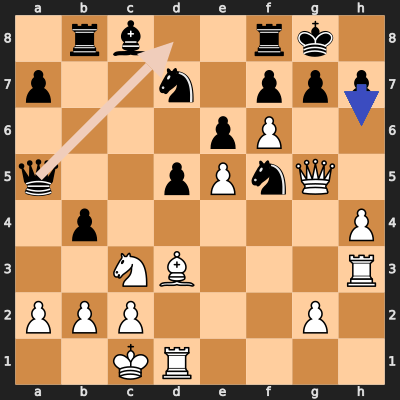

,Source,Puzzle_ID,FEN,Move,Move_UCI,Model,Predicted_Move,wp,cp,acierto,wp_stockfish,wp_best_stockfish,perdida_wp,acierto_stockfish,acierto_combinado,error_alineamiento
875,CBP_HARD,176CBP,1rb2rk1/p2n1ppp/4pP2/q2pPnQ1/1p5P/2NB3R/PPP3P1...,h6,h7h6,136M_results,h7h6,0.769431,327.0,True,0.481598,0.481598,0.000000,True,Ambos aciertan,0.287833
876,CBP_HARD,176CBP,1rb2rk1/p2n1ppp/4pP2/q2pPnQ1/1p5P/2NB3R/PPP3P1...,h6,h7h6,270M_results,h7h6,0.752622,302.0,True,0.481598,0.481598,0.000000,True,Ambos aciertan,0.271024
877,CBP_HARD,176CBP,1rb2rk1/p2n1ppp/4pP2/q2pPnQ1/1p5P/2NB3R/PPP3P1...,h6,h7h6,9M_results,h7h6,0.693346,221.0,True,0.481598,0.481598,0.000000,True,Ambos aciertan,0.211748
878,CBP_HARD,176CBP,1rb2rk1/p2n1ppp/4pP2/q2pPnQ1/1p5P/2NB3R/PPP3P1...,h6,h7h6,stockfish_all_moves_results,a5d8,0.416113,-92.0,False,0.334356,0.481598,0.147242,True,Acierta Stockfish,0.081757
879,CBP_HARD,176CBP,1rb2rk1/p2n1ppp/4pP2/q2pPnQ1/1p5P/2NB3R/PPP3P1...,h6,h7h6,stockfish_all_moves_results_20depth,h7h6,0.481598,-20.0,True,0.481598,0.481598,0.000000,True,Ambos aciertan,0.000000


Puzzle ID: 196CBP


/tmp/ipykernel_2465481/1499181793.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("coolwarm")  # o "Reds", "YlOrRd", etc.


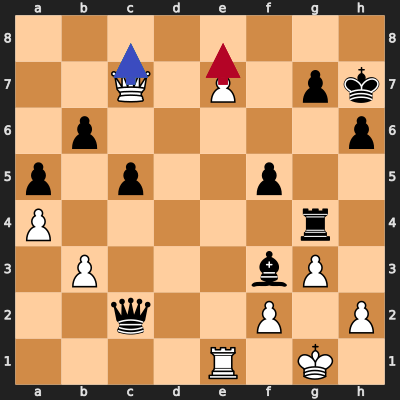

,Source,Puzzle_ID,FEN,Move,Move_UCI,Model,Predicted_Move,wp,cp,acierto,wp_stockfish,wp_best_stockfish,perdida_wp,acierto_stockfish,acierto_combinado,error_alineamiento
970,CBP_HARD,196CBP,8/2Q1P1pk/1p5p/p1p2p2/P5r1/1P3bP1/2q2P1P/4R1K1...,Qc8,c7c8,136M_results,e7e8q,0.790888,361.0,False,0.505523,0.88492,0.379397,True,Acierta Stockfish,0.285365
971,CBP_HARD,196CBP,8/2Q1P1pk/1p5p/p1p2p2/P5r1/1P3bP1/2q2P1P/4R1K1...,Qc8,c7c8,270M_results,e7e8q,0.707615,240.0,False,0.505523,0.88492,0.379397,True,Acierta Stockfish,0.202092
972,CBP_HARD,196CBP,8/2Q1P1pk/1p5p/p1p2p2/P5r1/1P3bP1/2q2P1P/4R1K1...,Qc8,c7c8,9M_results,e7e8q,0.841269,452.0,False,0.505523,0.88492,0.379397,True,Acierta Stockfish,0.335746
973,CBP_HARD,196CBP,8/2Q1P1pk/1p5p/p1p2p2/P5r1/1P3bP1/2q2P1P/4R1K1...,Qc8,c7c8,stockfish_all_moves_results,c7c8,0.862636,499.0,True,0.884920,0.88492,0.000000,True,Ambos aciertan,-0.022284
974,CBP_HARD,196CBP,8/2Q1P1pk/1p5p/p1p2p2/P5r1/1P3bP1/2q2P1P/4R1K1...,Qc8,c7c8,stockfish_all_moves_results_20depth,c7c8,0.884920,554.0,True,0.884920,0.88492,0.000000,True,Ambos aciertan,0.000000


Puzzle ID: 127CBP


/tmp/ipykernel_2465481/1499181793.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("coolwarm")  # o "Reds", "YlOrRd", etc.


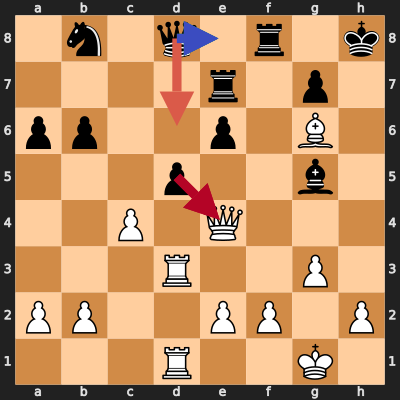

,Source,Puzzle_ID,FEN,Move,Move_UCI,Model,Predicted_Move,wp,cp,acierto,wp_stockfish,wp_best_stockfish,perdida_wp,acierto_stockfish,acierto_combinado,error_alineamiento
630,CBP_HARD,127CBP,1n1q1r1k/4r1p1/pp2p1B1/3p2b1/2P1Q3/3R2P1/PP2PP...,Qe8,d8e8,136M_results,d8d6,0.420465,-87.0,False,0.470577,0.691337,0.220759,True,Acierta Stockfish,-0.050112
631,CBP_HARD,127CBP,1n1q1r1k/4r1p1/pp2p1B1/3p2b1/2P1Q3/3R2P1/PP2PP...,Qe8,d8e8,270M_results,d5e4,0.492790,-7.0,False,0.204454,0.691337,0.486883,True,Acierta Stockfish,0.288337
632,CBP_HARD,127CBP,1n1q1r1k/4r1p1/pp2p1B1/3p2b1/2P1Q3/3R2P1/PP2PP...,Qe8,d8e8,9M_results,d5e4,0.430907,-75.0,False,0.204454,0.691337,0.486883,True,Acierta Stockfish,0.226453
633,CBP_HARD,127CBP,1n1q1r1k/4r1p1/pp2p1B1/3p2b1/2P1Q3/3R2P1/PP2PP...,Qe8,d8e8,stockfish_all_moves_results,d8e8,0.685810,212.0,True,0.691337,0.691337,0.000000,True,Ambos aciertan,-0.005527
634,CBP_HARD,127CBP,1n1q1r1k/4r1p1/pp2p1B1/3p2b1/2P1Q3/3R2P1/PP2PP...,Qe8,d8e8,stockfish_all_moves_results_20depth,d8e8,0.691337,219.0,True,0.691337,0.691337,0.000000,True,Ambos aciertan,0.000000


/tmp/ipykernel_2465481/1499181793.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("coolwarm")  # o "Reds", "YlOrRd", etc.


Puzzle ID: 197CBP


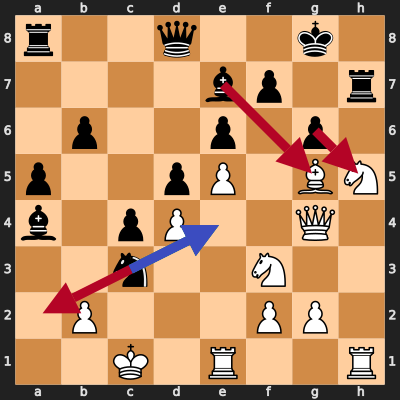

,Source,Puzzle_ID,FEN,Move,Move_UCI,Model,Predicted_Move,wp,cp,acierto,wp_stockfish,wp_best_stockfish,perdida_wp,acierto_stockfish,acierto_combinado,error_alineamiento
975,CBP_HARD,197CBP,r2q2k1/4bp1r/1p2p1p1/p2pP1BN/b1pP2Q1/2n2N2/1P3...,Ne4,c3e4,136M_results,e7g5,0.454305,-49.0,False,0.232724,0.5,0.267276,True,Acierta Stockfish,0.221582
976,CBP_HARD,197CBP,r2q2k1/4bp1r/1p2p1p1/p2pP1BN/b1pP2Q1/2n2N2/1P3...,Ne4,c3e4,270M_results,c3a2,0.490200,-10.0,False,0.203259,0.5,0.296741,True,Acierta Stockfish,0.286941
977,CBP_HARD,197CBP,r2q2k1/4bp1r/1p2p1p1/p2pP1BN/b1pP2Q1/2n2N2/1P3...,Ne4,c3e4,9M_results,g6h5,0.511737,12.0,False,0.160174,0.5,0.339826,True,Acierta Stockfish,0.351564
978,CBP_HARD,197CBP,r2q2k1/4bp1r/1p2p1p1/p2pP1BN/b1pP2Q1/2n2N2/1P3...,Ne4,c3e4,stockfish_all_moves_results,c3e4,0.462330,-41.0,True,0.500000,0.5,0.000000,True,Ambos aciertan,-0.037670
979,CBP_HARD,197CBP,r2q2k1/4bp1r/1p2p1p1/p2pP1BN/b1pP2Q1/2n2N2/1P3...,Ne4,c3e4,stockfish_all_moves_results_20depth,c3e4,0.500000,0.0,True,0.500000,0.5,0.000000,True,Ambos aciertan,0.000000


Puzzle ID: 096CBP


/tmp/ipykernel_2465481/1499181793.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("coolwarm")  # o "Reds", "YlOrRd", etc.


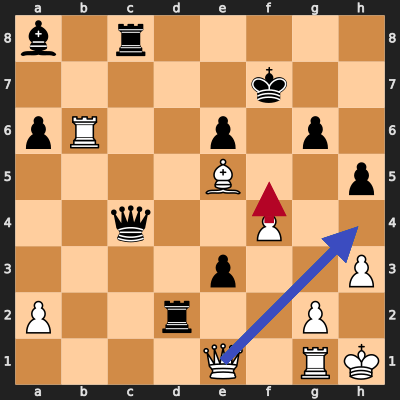

,Source,Puzzle_ID,FEN,Move,Move_UCI,Model,Predicted_Move,wp,cp,acierto,wp_stockfish,wp_best_stockfish,perdida_wp,acierto_stockfish,acierto_combinado,error_alineamiento
475,CBP_HARD,096CBP,b1r5/5k2/pR2p1p1/4B2p/2q2P2/4p2P/P2r2P1/4Q1RK ...,Qh4,e1h4,136M_results,f4f5,0.327111,-195.0,False,0.045590,0.614821,0.569231,True,Acierta Stockfish,0.281520
476,CBP_HARD,096CBP,b1r5/5k2/pR2p1p1/4B2p/2q2P2/4p2P/P2r2P1/4Q1RK ...,Qh4,e1h4,270M_results,f4f5,0.327379,-195.0,False,0.045590,0.614821,0.569231,True,Acierta Stockfish,0.281789
477,CBP_HARD,096CBP,b1r5/5k2/pR2p1p1/4B2p/2q2P2/4p2P/P2r2P1/4Q1RK ...,Qh4,e1h4,9M_results,e1h4,0.456477,-47.0,True,0.614821,0.614821,0.000000,True,Ambos aciertan,-0.158344
478,CBP_HARD,096CBP,b1r5/5k2/pR2p1p1/4B2p/2q2P2/4p2P/P2r2P1/4Q1RK ...,Qh4,e1h4,stockfish_all_moves_results,e1h4,0.500000,0.0,True,0.614821,0.614821,0.000000,True,Ambos aciertan,-0.114821
479,CBP_HARD,096CBP,b1r5/5k2/pR2p1p1/4B2p/2q2P2/4p2P/P2r2P1/4Q1RK ...,Qh4,e1h4,stockfish_all_moves_results_20depth,e1h4,0.614821,127.0,True,0.614821,0.614821,0.000000,True,Ambos aciertan,0.000000


/tmp/ipykernel_2465481/1499181793.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("coolwarm")  # o "Reds", "YlOrRd", etc.


Puzzle ID: 109SBPH


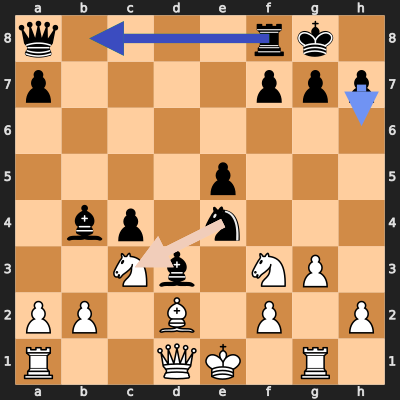

,Source,Puzzle_ID,FEN,Move,Move_UCI,Model,Predicted_Move,wp,cp,acierto,wp_stockfish,wp_best_stockfish,perdida_wp,acierto_stockfish,acierto_combinado,error_alineamiento
1095,SBP_HARD,109SBPH,q4rk1/p4ppp/8/4p3/1bp1n3/2Nb1NP1/PP1B1P1P/R2QK...,Rb8,f8b8,136M_results,e4c3,0.666252,187.0,False,0.500000,0.64822,0.148220,True,Acierta Stockfish,0.166252
1096,SBP_HARD,109SBPH,q4rk1/p4ppp/8/4p3/1bp1n3/2Nb1NP1/PP1B1P1P/R2QK...,Rb8,f8b8,270M_results,e4c3,0.780127,343.0,False,0.500000,0.64822,0.148220,True,Acierta Stockfish,0.280127
1097,SBP_HARD,109SBPH,q4rk1/p4ppp/8/4p3/1bp1n3/2Nb1NP1/PP1B1P1P/R2QK...,Rb8,f8b8,9M_results,e4c3,0.691913,219.0,False,0.500000,0.64822,0.148220,True,Acierta Stockfish,0.191913
1098,SBP_HARD,109SBPH,q4rk1/p4ppp/8/4p3/1bp1n3/2Nb1NP1/PP1B1P1P/R2QK...,Rb8,f8b8,stockfish_all_moves_results,h7h6,0.649898,168.0,False,0.606065,0.64822,0.042155,True,Acierta Stockfish,0.043832
1099,SBP_HARD,109SBPH,q4rk1/p4ppp/8/4p3/1bp1n3/2Nb1NP1/PP1B1P1P/R2QK...,Rb8,f8b8,stockfish_all_moves_results_20depth,f8b8,0.648220,166.0,True,0.648220,0.64822,0.000000,True,Ambos aciertan,0.000000


Puzzle ID: 162CBP


/tmp/ipykernel_2465481/1499181793.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("coolwarm")  # o "Reds", "YlOrRd", etc.


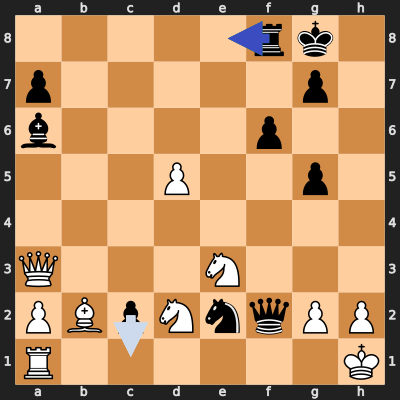

,Source,Puzzle_ID,FEN,Move,Move_UCI,Model,Predicted_Move,wp,cp,acierto,wp_stockfish,wp_best_stockfish,perdida_wp,acierto_stockfish,acierto_combinado,error_alineamiento
805,CBP_HARD,162CBP,5rk1/p5p1/b4p2/3P2p1/8/Q3N3/PBpNnqPP/R6K b - -...,Re8,f8e8,136M_results,c2c1q,0.745602,292.0,False,0.578510,0.686602,0.108093,True,Acierta Stockfish,0.167092
806,CBP_HARD,162CBP,5rk1/p5p1/b4p2/3P2p1/8/Q3N3/PBpNnqPP/R6K b - -...,Re8,f8e8,270M_results,c2c1r,0.819456,410.0,False,0.563176,0.686602,0.123426,True,Acierta Stockfish,0.256280
807,CBP_HARD,162CBP,5rk1/p5p1/b4p2/3P2p1/8/Q3N3/PBpNnqPP/R6K b - -...,Re8,f8e8,9M_results,c2c1b,0.689632,216.0,False,0.575814,0.686602,0.110788,True,Acierta Stockfish,0.113818
808,CBP_HARD,162CBP,5rk1/p5p1/b4p2/3P2p1/8/Q3N3/PBpNnqPP/R6K b - -...,Re8,f8e8,stockfish_all_moves_results,f8e8,0.654075,173.0,True,0.686602,0.686602,0.000000,True,Ambos aciertan,-0.032528
809,CBP_HARD,162CBP,5rk1/p5p1/b4p2/3P2p1/8/Q3N3/PBpNnqPP/R6K b - -...,Re8,f8e8,stockfish_all_moves_results_20depth,f8e8,0.686602,213.0,True,0.686602,0.686602,0.000000,True,Ambos aciertan,0.000000


/tmp/ipykernel_2465481/1499181793.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("coolwarm")  # o "Reds", "YlOrRd", etc.


Puzzle ID: 198CBP


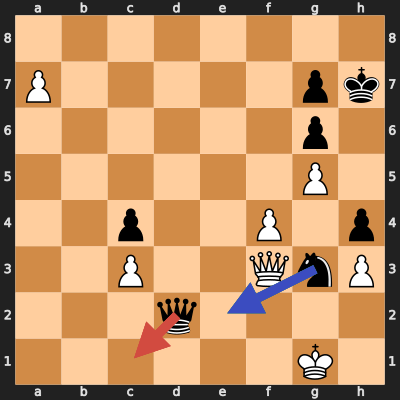

,Source,Puzzle_ID,FEN,Move,Move_UCI,Model,Predicted_Move,wp,cp,acierto,wp_stockfish,wp_best_stockfish,perdida_wp,acierto_stockfish,acierto_combinado,error_alineamiento
980,CBP_HARD,198CBP,8/P5pk/6p1/6P1/2p2P1p/2P2QnP/3q4/6K1 b - - 0 1,Ne2+,g3e2,136M_results,d2c1,0.743862,289.0,False,0.500000,0.728455,0.228455,True,Acierta Stockfish,0.243862
981,CBP_HARD,198CBP,8/P5pk/6p1/6P1/2p2P1p/2P2QnP/3q4/6K1 b - - 0 1,Ne2+,g3e2,270M_results,d2c1,0.753176,302.0,False,0.500000,0.728455,0.228455,True,Acierta Stockfish,0.253176
982,CBP_HARD,198CBP,8/P5pk/6p1/6P1/2p2P1p/2P2QnP/3q4/6K1 b - - 0 1,Ne2+,g3e2,9M_results,d2c1,0.777027,339.0,False,0.500000,0.728455,0.228455,True,Acierta Stockfish,0.277027
983,CBP_HARD,198CBP,8/P5pk/6p1/6P1/2p2P1p/2P2QnP/3q4/6K1 b - - 0 1,Ne2+,g3e2,stockfish_all_moves_results,g3e2,0.720369,257.0,True,0.728455,0.728455,0.000000,True,Ambos aciertan,-0.008086
984,CBP_HARD,198CBP,8/P5pk/6p1/6P1/2p2P1p/2P2QnP/3q4/6K1 b - - 0 1,Ne2+,g3e2,stockfish_all_moves_results_20depth,g3e2,0.728455,268.0,True,0.728455,0.728455,0.000000,True,Ambos aciertan,0.000000


Puzzle ID: 165CBP


/tmp/ipykernel_2465481/1499181793.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("coolwarm")  # o "Reds", "YlOrRd", etc.


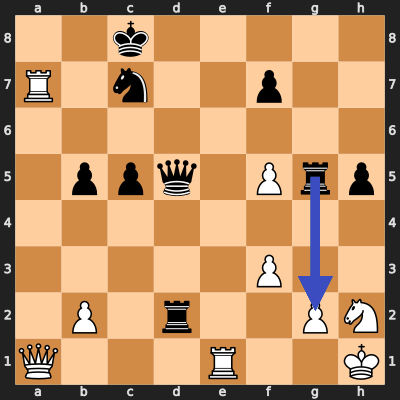

,Source,Puzzle_ID,FEN,Move,Move_UCI,Model,Predicted_Move,wp,cp,acierto,wp_stockfish,wp_best_stockfish,perdida_wp,acierto_stockfish,acierto_combinado,error_alineamiento
820,CBP_HARD,165CBP,2k5/R1n2p2/8/1ppq1Prp/8/5P2/1P1r2PN/Q3R2K b - ...,Rgxg2,g5g2,136M_results,g5g2,0.639863,156.0,True,0.5,0.5,0.0,True,Ambos aciertan,0.139863
821,CBP_HARD,165CBP,2k5/R1n2p2/8/1ppq1Prp/8/5P2/1P1r2PN/Q3R2K b - ...,Rgxg2,g5g2,270M_results,g5g2,0.753013,302.0,True,0.5,0.5,0.0,True,Ambos aciertan,0.253013
822,CBP_HARD,165CBP,2k5/R1n2p2/8/1ppq1Prp/8/5P2/1P1r2PN/Q3R2K b - ...,Rgxg2,g5g2,9M_results,g5g2,0.834647,439.0,True,0.5,0.5,0.0,True,Ambos aciertan,0.334647
823,CBP_HARD,165CBP,2k5/R1n2p2/8/1ppq1Prp/8/5P2/1P1r2PN/Q3R2K b - ...,Rgxg2,g5g2,stockfish_all_moves_results,g5g2,0.500000,0.0,True,0.5,0.5,0.0,True,Ambos aciertan,0.000000
824,CBP_HARD,165CBP,2k5/R1n2p2/8/1ppq1Prp/8/5P2/1P1r2PN/Q3R2K b - ...,Rgxg2,g5g2,stockfish_all_moves_results_20depth,g5g2,0.500000,0.0,True,0.5,0.5,0.0,True,Ambos aciertan,0.000000


In [55]:
print('Numero de puzzles:', len(df_desalineamiento['Puzzle_ID'].unique()))
for puzzle_idx in df_desalineamiento['Puzzle_ID'].unique():
    analiza_problema(puzzle_idx, saturacion_error = 0.25)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=e7cf07c1-de09-4e38-bb47-f3f0b59850b1' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>